# **Imports**

In [19]:
from scipy import stats

In [20]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.metrics import confusion_matrix, f1_score, make_scorer, classification_report, balanced_accuracy_score, roc_auc_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, RepeatedStratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

In [21]:
import pandas as pd
import numpy as np
from scipy import sparse

%matplotlib inline
import matplotlib.pylab as plt

import seaborn as sns

from tqdm import tqdm_notebook

import os
import itertools
import glob

import warnings
warnings.filterwarnings('ignore')

from scipy.io import loadmat

from datetime import datetime, date, time

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) #, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid('off')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def plot_matrices(y_true, y_pred):
    class_names =range(1, 3)

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    #plt.savefig("ConMatrix.png")

    # Plot normalized confusion matrix
    plt.figure(figsize=(4, 3))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()
    #plt.savefig("ConMatrixNorm.png")


def plot_coef(model_coeff, df, figsize=(25, 12), num_feat=150):

    coef_arr = np.abs(model_coeff).sum(axis=0)

    column_list = list(df)
    coef_list = list(coef_arr)

    coef_df = pd.DataFrame(coef_list)
    coef_df = coef_df.T
    coef_df.columns=column_list

    coef_df.sort_values(by=0, axis=1).iloc[0, :].tail(num_feat).plot(kind="bar", figsize=figsize, legend=None)

def brute_feat_gen(df, cols, add_3=True, add_2=True, add_sqrt=True):
    for name1 in tqdm_notebook(cols):
        for name2 in cols:
            for name3 in cols:
                if add_3:
                    df[name1 + "_X_" + name2 + "_X_" + name3] =  df[name1] * df[name2] * df[name3]
                if add_2:
                    df[name1 + "_X_" + name2] =  df[name1] * df[name2]
                if add_sqrt:
                    df["sqrt_" + name1] =  np.sqrt(df[name1])
    print( df.shape)
    return df



def feat_gen(df, cols, degree=2, interaction_only=False, add_sqrt=True):

    print( "Shape of input: ", df.shape)

    poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
    arr = poly.fit_transform(df[cols])
    header = poly.get_feature_names(input_features=list(df[cols]))
    temp_df = pd.DataFrame(arr)
    temp_df.columns=header

    if add_sqrt:
        if not (temp_df[cols] >= 0).all().all():
            print("Negative values in df! They would cause NaN values!")
        for col_name in cols:
            temp_df["sqrt_" + col_name] =  np.sqrt(temp_df[col_name])

    df.drop(cols, axis=1, inplace=True)

    result_df = pd.concat([df, temp_df], axis=1, join_axes=[df.index])

    print( "Shape of output: ", result_df.shape)

    return result_df

# **Regression Task**

## **1. Data preparation**

In [25]:
car_data = pd.read_csv('../../data/car data.csv')

# OHE variants
only pandas variant

In [82]:
df_onehot = pd.get_dummies(car_data, columns=['Fuel_Type', 'Seller_Type', "Transmission"], drop_first=True)
df_onehot.head()

,Selling_Price,Present_Price,Kms_Driven,Owner,Years_ago,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Individual,Transmission_Manual
0,3.35,5.59,27000,0,4,0,1,0,1
1,4.75,9.54,43000,0,5,1,0,0,1
2,7.25,9.85,6900,0,1,0,1,0,1
3,2.85,4.15,5200,0,7,0,1,0,1
4,4.60,6.87,42450,0,4,1,0,0,1


# OHE SK-Learn and Pandas

In [85]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore' )

# Select only the categorical columns for encoding
categorical_cols = ['Fuel_Type', 'Seller_Type', "Transmission"]
X_categorical = car_data[categorical_cols]

# Fit and transform the categorical data
onehot_encoded = encoder.fit_transform(X_categorical)

# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the encoded DataFrame with the original numerical columns
df_onehot = pd.concat([car_data.drop(columns=categorical_cols), encoded_df], axis=1)

# Display the result
print("\nOne-Hot Encoded DataFrame:")
df_onehot.head()


One-Hot Encoded DataFrame:


,Selling_Price,Present_Price,Kms_Driven,Owner,Years_ago,Fuel_Type_CNG,Fuel_Type_Diesel,Fuel_Type_Petrol,Seller_Type_Dealer,Seller_Type_Individual,Transmission_Automatic,Transmission_Manual
0,3.35,5.59,27000,0,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,4.75,9.54,43000,0,5,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,7.25,9.85,6900,0,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,2.85,4.15,5200,0,7,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,4.60,6.87,42450,0,4,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [26]:
car_data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [27]:
car_data.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [28]:
car_data.shape

(301, 9)

In [29]:
car_data['Years_ago'] = car_data.Year.max() - car_data.Year # reducing the scale
car_data.drop('Year', axis=1, inplace=True)

In [30]:
car_data.describe()

,Selling_Price,Present_Price,Kms_Driven,Owner,Years_ago
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,4.661296,7.628472,36947.205980,0.043189,4.372093
std,5.082812,8.644115,38886.883882,0.247915,2.891554
min,0.100000,0.320000,500.000000,0.000000,0.000000
25%,0.900000,1.200000,15000.000000,0.000000,2.000000
50%,3.600000,6.400000,32000.000000,0.000000,4.000000
75%,6.000000,9.900000,48767.000000,0.000000,6.000000
max,35.000000,92.600000,500000.000000,3.000000,15.000000


In [31]:
car_data.Car_Name.nunique() # It would be nice to encode, but in our case it will be easier to get rid of

98

In [32]:
car_data.drop('Car_Name', axis=1, inplace=True)

In [33]:
car_data.isna().sum() # luckily data is without missing values

Selling_Price    0
Present_Price    0
Kms_Driven       0
Fuel_Type        0
Seller_Type      0
Transmission     0
Owner            0
Years_ago        0
dtype: int64

In [34]:
for attr in car_data.columns:
  print(car_data[attr].value_counts())

0.45     8
0.60     8
5.25     7
4.50     7
0.20     6
        ..
3.80     1
3.45     1
5.90     1
35.00    1
11.50    1
Name: Selling_Price, Length: 156, dtype: int64
9.40     15
13.60    13
5.70      8
4.43      7
1.47      7
         ..
18.54     1
7.27      1
15.04     1
10.21     1
12.50     1
Name: Present_Price, Length: 147, dtype: int64
45000    9
15000    9
40000    5
35000    5
50000    5
        ..
1400     1
1200     1
4100     1
21700    1
5464     1
Name: Kms_Driven, Length: 206, dtype: int64
Petrol    239
Diesel     60
CNG         2
Name: Fuel_Type, dtype: int64
Dealer        195
Individual    106
Name: Seller_Type, dtype: int64
Manual       261
Automatic     40
Name: Transmission, dtype: int64
0    290
1     10
3      1
Name: Owner, dtype: int64
3     61
2     50
4     38
1     35
5     33
6     23
7     19
8     15
10     7
9      6
12     4
13     4
15     2
11     2
0      1
14     1
Name: Years_ago, dtype: int64


Usually the data is divided into 3 sets, but 2 are enough for us (for educational purposes).

In [35]:
X_train, X_val, y_train, y_val = train_test_split(car_data.drop('Selling_Price', axis=1), # data without target
                                                  car_data['Selling_Price'],              # the target
                                                  test_size=0.3,                     # size of the test
                                                  random_state=42)                  # fixing the sample

In [36]:
for sample in [X_train, X_val]:
  print(sample.shape)

(210, 7)
(91, 7)


As you can see, all our features have a different distribution from the normal one.

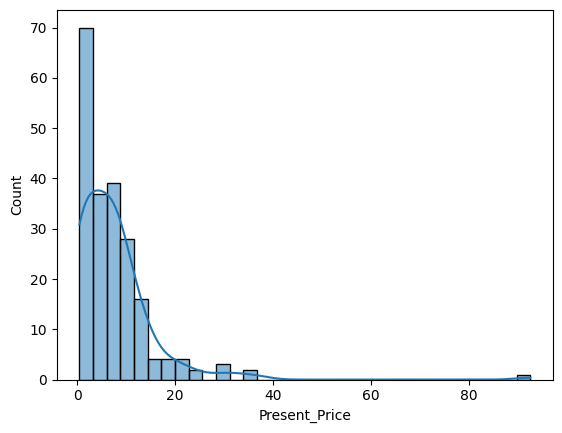

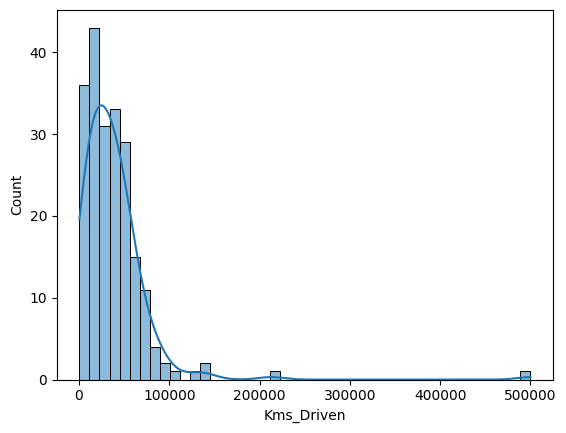

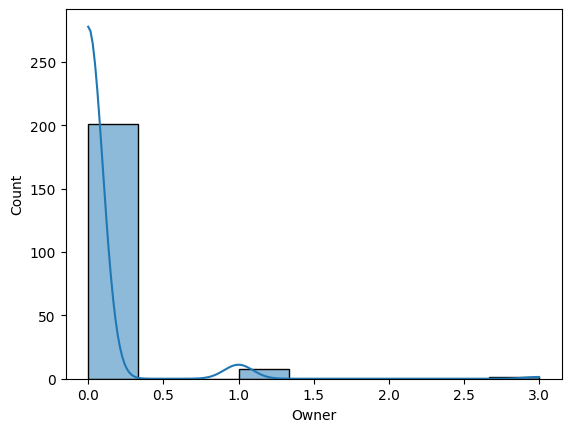

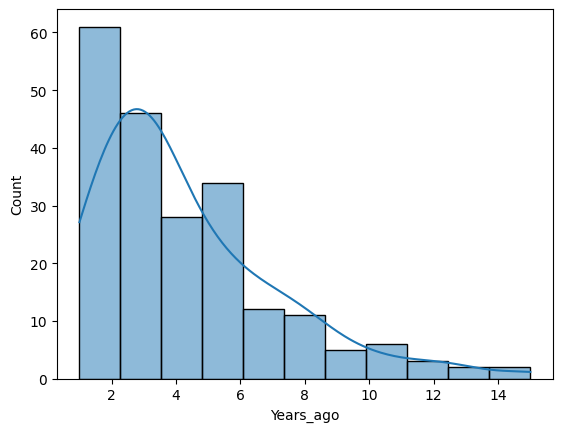

In [37]:
for attr in X_train.select_dtypes(include=[float, int]):
  ax = sns.histplot(x=X_train[attr], kde=True)
  plt.show()

Let us get rid of a few outliers

In [38]:
z = stats.zscore(X_train[['Present_Price', 'Kms_Driven']])

In [39]:
z_mask = (np.abs(z) > 3).any(axis = 1)
X_train = X_train[~z_mask]
y_train = y_train[~z_mask]

In [40]:
X_train.loc[X_train['Owner'] == 3, 'Owner'] = 1

In [41]:
X_train.Owner.value_counts()

0    196
1      9
Name: Owner, dtype: int64

And we will perform a log transformation of some of the numeric features:

In [42]:
cor_matrix = X_train.join(y_train).corr()


<AxesSubplot: >

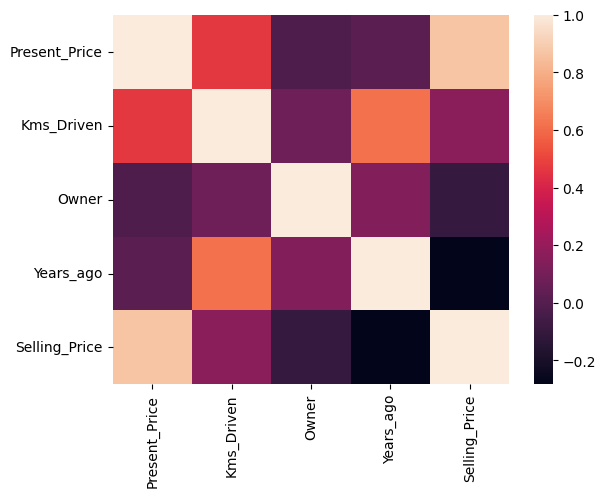

In [45]:
import seaborn as sns


sns.heatmap(X_train.join(y_train).corr())

In [46]:
log_cor_matrix = np.log(X_train.join(y_train).select_dtypes(include=[float, int]) + 0.001).corr()
log_cor_matrix

,Present_Price,Kms_Driven,Owner,Years_ago,Selling_Price
Present_Price,1.000000,0.398767,-0.038487,-0.019113,0.948659
Kms_Driven,0.398767,1.000000,0.047824,0.572545,0.214700
Owner,-0.038487,0.047824,1.000000,0.135759,-0.112636
Years_ago,-0.019113,0.572545,0.135759,1.000000,-0.267965
Selling_Price,0.948659,0.214700,-0.112636,-0.267965,1.000000


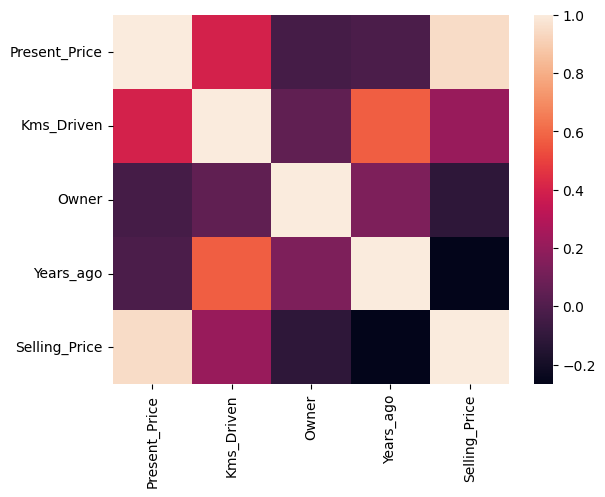

In [47]:
sns.heatmap(log_cor_matrix);

In fact, of only one feature

In [48]:
X_train['Kms_Driven_log'] = np.log(X_train['Kms_Driven'] + 0.001)
X_train.drop('Kms_Driven', axis=1, inplace=True)

X_val['Kms_Driven_log'] = np.log(X_val['Kms_Driven'] + 0.001)
X_val.drop('Kms_Driven', axis=1, inplace=True)

In [49]:
X_train.join(y_train).corr()

,Present_Price,Owner,Years_ago,Kms_Driven_log,Selling_Price
Present_Price,1.000000,-0.021325,0.021079,0.400688,0.865487
Owner,-0.021325,1.000000,0.140262,0.047824,-0.100243
Years_ago,0.021079,0.140262,1.000000,0.496942,-0.283503
Kms_Driven_log,0.400688,0.047824,0.496942,1.000000,0.200910
Selling_Price,0.865487,-0.100243,-0.283503,0.200910,1.000000


Now let us encode the categories:

In [50]:
car_data.head(2)

,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner,Years_ago
0,3.35,5.59,27000,Petrol,Dealer,Manual,0,4
1,4.75,9.54,43000,Diesel,Dealer,Manual,0,5


In [51]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
X_train["exp_with_ohe"] = enc.fit_transform(X_train[["Fuel_Type"]])
# pd.DataFrame(encoded, columns=enc.get_feature_names_out())
# enc.fit_transform(X_train)
encoded

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [52]:
X_train.Transmission.unique()

array(['Automatic', 'Manual'], dtype=object)

In [53]:
from sklearn.preprocessing import LabelEncoder as Encoder

enc = Encoder()


X_train["Fuel_Type"] = enc.fit_transform(X_train["Fuel_Type"])
X_train["Seller_Type"] = enc.fit_transform(X_train["Seller_Type"])
X_train["Transmission"] = enc.fit_transform(X_train["Transmission"])

In [54]:
X_val["Fuel_Type"] = enc.fit_transform(X_val["Fuel_Type"])
X_val["Seller_Type"] = enc.fit_transform(X_val["Seller_Type"])
X_val["Transmission"] = enc.fit_transform(X_val["Transmission"])

In [55]:
X_train

,Present_Price,Fuel_Type,Seller_Type,Transmission,Owner,Years_ago,Kms_Driven_log
185,0.58,2,1,0,0,10,7.549610
72,18.61,2,0,1,0,5,10.933125
15,10.79,1,0,1,0,2,10.668955
10,3.60,2,0,1,0,1,7.666222
298,11.00,2,0,1,0,9,11.384342
...,...,...,...,...,...,...,...
188,0.57,2,1,1,0,5,9.798127
71,12.48,1,0,1,0,7,10.714418
106,3.45,2,1,1,1,4,9.711116
270,10.00,2,0,1,0,7,11.146792


In [56]:
X_train["Fuel_Type_Petrol"] = X_train.Fuel_Type

X_train["Fuel_Type_Petrol"] = X_train.Fuel_Type_Petrol.replace("Petrol", 1)
X_train["Fuel_Type_Petrol"] = X_train.Fuel_Type_Petrol.replace("Diesel", 0)
X_train["Fuel_Type_Petrol"] = X_train.Fuel_Type_Petrol.replace("CNG", 0)

X_train["Fuel_Type_Diesel"] = X_train.Fuel_Type_Petrol.replace("Petrol", 0)
X_train["Fuel_Type_Diesel"] = X_train.Fuel_Type_Petrol.replace("Diesel", 1)
X_train["Fuel_Type_Diesel"] = X_train.Fuel_Type_Petrol.replace("CNG", 0)

In [57]:
X_train["Seller_Type_Individual"] = X_train.Seller_Type

X_train["Seller_Type_Individual"] = X_train.Seller_Type_Individual.replace("Individual", 1)
X_train["Seller_Type_Individual"] = X_train.Seller_Type_Individual.replace("Dealer", 0)
X_train["Transmission_Automatic"] = X_train.Transmission

X_train["Transmission_Automatic"] = X_train.Transmission_Automatic.replace("Manual", 0)
X_train["Transmission_Automatic"] = X_train.Transmission_Automatic.replace("Automatic", 1)


In [58]:
X_val["Fuel_Type_Petrol"] = X_val.Fuel_Type

X_val["Fuel_Type_Petrol"] = X_val.Fuel_Type_Petrol.replace("Petrol", 1)
X_val["Fuel_Type_Petrol"] = X_val.Fuel_Type_Petrol.replace("Diesel", 0)
X_val["Fuel_Type_Petrol"] = X_val.Fuel_Type_Petrol.replace("CNG", 0)

X_val["Fuel_Type_Diesel"] = X_val.Fuel_Type_Petrol.replace("Petrol", 0)
X_val["Fuel_Type_Diesel"] = X_val.Fuel_Type_Petrol.replace("Diesel", 1)
X_val["Fuel_Type_Diesel"] = X_val.Fuel_Type_Petrol.replace("CNG", 0)

X_val["Seller_Type_Individual"] = X_val.Seller_Type

X_val["Seller_Type_Individual"] = X_val.Seller_Type_Individual.replace("Individual", 1)
X_val["Seller_Type_Individual"] = X_val.Seller_Type_Individual.replace("Dealer", 0)
X_val["Transmission_Automatic"] = X_val.Transmission

X_val["Transmission_Automatic"] = X_val.Transmission_Automatic.replace("Manual", 0)
X_val["Transmission_Automatic"] = X_val.Transmission_Automatic.replace("Automatic", 1)

In [59]:
X_val.drop(["Fuel_Type","Seller_Type", "Transmission" ], axis=1)

,Present_Price,Owner,Years_ago,Kms_Driven_log,Fuel_Type_Petrol,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Automatic
177,0.57,0,2,10.085809,1,1,1,0
289,13.60,0,2,9.303831,1,1,0,1
228,9.40,0,6,11.002100,0,0,0,1
198,0.57,1,7,10.463103,1,1,1,1
60,18.61,0,5,10.596660,1,1,0,1
...,...,...,...,...,...,...,...,...
119,1.90,0,5,8.594154,1,1,1,1
19,7.98,0,8,10.632050,1,1,0,1
181,0.48,0,2,10.819778,1,1,1,1
79,30.61,0,6,11.396392,0,0,0,0


In [60]:
X_train.drop(["Fuel_Type","Seller_Type", "Transmission" ], axis=1)

,Present_Price,Owner,Years_ago,Kms_Driven_log,Fuel_Type_Petrol,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Automatic
185,0.58,0,10,7.549610,2,2,1,0
72,18.61,0,5,10.933125,2,2,0,1
15,10.79,0,2,10.668955,1,1,0,1
10,3.60,0,1,7.666222,2,2,0,1
298,11.00,0,9,11.384342,2,2,0,1
...,...,...,...,...,...,...,...,...
188,0.57,0,5,9.798127,2,2,1,1
71,12.48,0,7,10.714418,1,1,0,1
106,3.45,1,4,9.711116,2,2,1,1
270,10.00,0,7,11.146792,2,2,0,1


In [61]:
y_train

185    0.25
72     7.45
15     7.75
10     2.85
298    3.35
       ... 
188    0.25
71     4.50
106    1.35
270    4.10
102    1.65
Name: Selling_Price, Length: 205, dtype: float64

<AxesSubplot: >

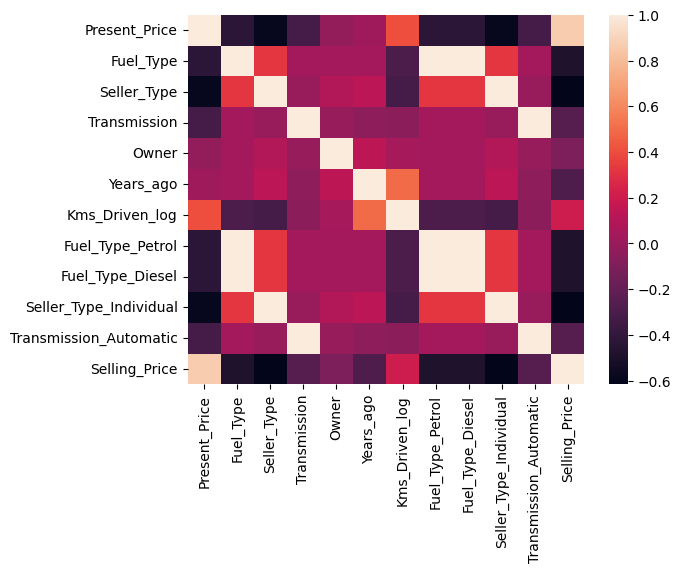

In [62]:
sns.heatmap(X_train.join(y_train).corr())


Let's make some datasets. In one case, let's try to predict the Selling price only by the Present Price. In the second case, we will remove all variables that correlate with the Present Price by more than 0.4. In the third case, we will leave everything as it is.

In [63]:
X_train_v1 = X_train[['Present_Price']]
X_train_v1.head()

,Present_Price
185,0.58
72,18.61
15,10.79
10,3.60
298,11.00


In [93]:
X_train

,Present_Price,Fuel_Type,Seller_Type,Transmission,Owner,Years_ago,Kms_Driven_log,Fuel_Type_Petrol,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Automatic
185,0.58,2,1,0,0,10,7.549610,2,2,1,0
72,18.61,2,0,1,0,5,10.933125,2,2,0,1
15,10.79,1,0,1,0,2,10.668955,1,1,0,1
10,3.60,2,0,1,0,1,7.666222,2,2,0,1
298,11.00,2,0,1,0,9,11.384342,2,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...
188,0.57,2,1,1,0,5,9.798127,2,2,1,1
71,12.48,1,0,1,0,7,10.714418,1,1,0,1
106,3.45,2,1,1,1,4,9.711116,2,2,1,1
270,10.00,2,0,1,0,7,11.146792,2,2,0,1


In [94]:
X_train_v2 = X_train[['Present_Price', 'Transmission_Automatic', 'Owner',
                      'Years_ago', 'Kms_Driven_log']]
X_train_v2.head()

,Present_Price,Transmission_Automatic,Owner,Years_ago,Kms_Driven_log
185,0.58,0,0,10,7.549610
72,18.61,1,0,5,10.933125
15,10.79,1,0,2,10.668955
10,3.60,1,0,1,7.666222
298,11.00,1,0,9,11.384342


In [95]:
X_train_v3 = X_train.copy()

In [96]:
X_val_v1 = X_val[['Present_Price']]
X_val_v2 = X_val[['Present_Price',  'Transmission_Automatic', 'Owner',
                      'Years_ago', 'Kms_Driven_log']]
X_val_v3 = X_val.copy()

In [97]:
X_val_v3

,Present_Price,Fuel_Type,Seller_Type,Transmission,Owner,Years_ago,Kms_Driven_log,Fuel_Type_Petrol,Fuel_Type_Diesel,Seller_Type_Individual,Transmission_Automatic
177,0.57,1,1,0,0,2,10.085809,1,1,1,0
289,13.60,1,0,1,0,2,9.303831,1,1,0,1
228,9.40,0,0,1,0,6,11.002100,0,0,0,1
198,0.57,1,1,1,1,7,10.463103,1,1,1,1
60,18.61,1,0,1,0,5,10.596660,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
119,1.90,1,1,1,0,5,8.594154,1,1,1,1
19,7.98,1,0,1,0,8,10.632050,1,1,0,1
181,0.48,1,1,1,0,2,10.819778,1,1,1,1
79,30.61,0,0,0,0,6,11.396392,0,0,0,0


## **2. Regression metrics**

**Quality metrics** - metrics that show how much the model is wrong in forecasting. A metric is used to judge the performance of your model. This is only for you to look at and, as opposed to loss functions, has nothing to do with the optimization process.  
[Here](http://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) you can read about regression metrics in sklearn.

* __Mean Squared Error__  
$$MSE = \frac{1}{n}\sum_{i=1}^{n}(a(x_{i}) - y_{i})^2$$

xi - the feature vector of i-th object; a - model of prediction; yi - true value of the target variable; a(xi) - the predicted value of the target variable

* __Root Mean Squared Error__
$$RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(a(x_{i}) - y_{i})^2}$$  
  
Helps to see the real deviation from the true values in its own units (and not in square ones).

* __Mean absolute error__
$$MAE = \frac{1}{n}\sum_{i=1}^{n}\left |a(x_{i}) - y_{i}\right |$$

Mean absolute error is used when there are a large number of outliers in the data (imagine the error if we square a giant value). In other cases, it is better to use MSE. MSE is typically used as a loss function (unlike MAE, it is differentiable).

All the same functions, but with a **median** (less sensitive to outliers).

* __Coefficient of determination (R2 coef)__  
Used to compare the $a(x)$ model with the average value of the target variable over the dataset (baseline) 


$R^{2} = 1 - \frac{\sum_{i=1}^{n}(a(x) - y_{i})^{2}}{\sum_{i=1}^{n}(\overline{y} - y_{i})^{2}},$ where $\overline{y}$ - mean value of the target variable over all objects in the train data.

$R^2 = 1$, the model is ideal  
$R^2 < 0$, the model is worse than the model that predicts only the mean value


$a(x) = \overline{y} $

In [68]:
from sklearn import metrics

In [69]:
def show_reg_metrics(y_preds, y_trues):
  mse = metrics.mean_squared_error(y_pred=y_preds,
                                 y_true=y_trues)
  rmse = np.sqrt(mse)
  mae = metrics.mean_absolute_error(y_pred=y_preds,
                                  y_true=y_trues)
  medae = metrics.median_absolute_error(y_pred=y_preds,
                                      y_true=y_trues)
  R2 = metrics.r2_score(y_pred=y_preds,
                      y_true=y_trues)
  print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse, rmse, R2, mae, medae))

In [70]:
show_reg_metrics([1.02, 9.05, 18, 10], [1, 10, 18.09, 10])

MSE:   0.22774999999999965
RMSE:  0.47723159995959996
R2:    0.9937705600153719
MAE:   0.2649999999999998
MedAE: 0.05499999999999994


In case you don't understand well how these metrics work, try to implement each of them yourself.
* __Mean Squared Error__  
$$MSE = \frac{1}{n}\sum_{i=1}^{n}(a(x_{i}) - y_{i})^2$$

In [71]:
a_x = [1, 9, 18, 10]
y = [1, 10, 20, 10]

enumerate

def MSE_Ulyana(y_pred, y_ans):
    metrics_val = 0 
    if len(y_pred) != len(y_ans):
        raise Exception()
    for i, val in enumerate(y_pred):
        metrics_val += (val - y_ans[i]) ** 2
    
    return metrics_val / len(y_pred)
        


In [72]:
MSE_Ulyana(a_x, y)

1.25

## **3. Parametric models: linear regression**

### **3.1 Linear Regression**

[Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

In [98]:
regressionModel = LinearRegression()

regressionModel.fit(X_train_v1, y_train)

LinearRegression()

In [99]:
y_pred = regressionModel.predict(X_val_v1)

<AxesSubplot: >

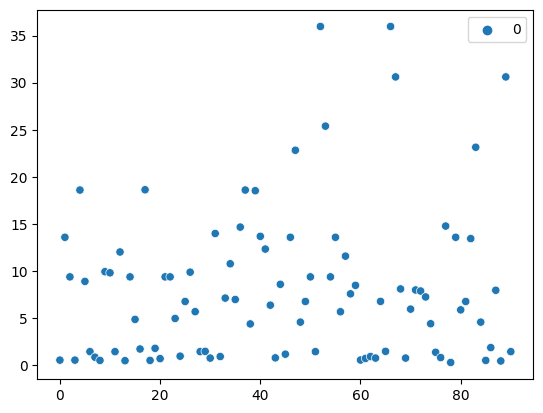

In [ ]:
sns.scatterplot(np.array( X_val_v1, y_train))

In [106]:
X_train_v1.head()

,Present_Price
185,0.58
72,18.61
15,10.79
10,3.60
298,11.00


In [107]:
X_train_v2.head()

,Present_Price,Transmission_Automatic,Owner,Years_ago,Kms_Driven_log
185,0.58,0,0,10,7.549610
72,18.61,1,0,5,10.933125
15,10.79,1,0,2,10.668955
10,3.60,1,0,1,7.666222
298,11.00,1,0,9,11.384342


In [111]:
y_val

177     0.35
289    10.11
228     4.95
198     0.15
60      6.95
       ...  
119     1.05
19      2.65
181     0.30
79     14.50
114     1.15
Name: Selling_Price, Length: 91, dtype: float64

In [100]:
y_pred # these are our predictions of the target

array([ 0.76366896,  8.10435363,  5.73820815,  0.76366896, 10.92682717,
        5.46779152,  1.27070014,  0.93831303,  0.74676792,  6.04806054,
        5.98045638,  1.27070014,  7.2254996 ,  0.72986688,  5.73820815,
        3.1974186 ,  1.42844317, 10.94372821,  0.74676792,  1.46787893,
        0.85380784,  5.73820815,  5.73820815,  3.2537554 ,  1.00028351,
        4.26781775,  6.01989214,  3.65938034,  1.27070014,  1.28760118,
        0.88591981,  8.32970082,  0.97774879,  4.47063021,  6.52128963,
        4.38612502,  8.71279104, 10.92682717,  2.92700197, 10.88739141,
        8.16069043,  7.40014367,  4.04810424,  0.89887728,  5.29314745,
        1.11859078,  8.10435363, 13.30424001,  3.03404189,  4.26781775,
        5.73820815,  1.27070014, 20.70126148, 14.74646202,  5.73820815,
        8.10435363,  3.65374666,  6.97761769,  4.7241458 ,  5.23117698,
        0.76930264,  0.8650752 ,  0.97774879,  0.88591981,  4.27345142,
        1.28760118, 20.70126148, 17.68724283,  5.01709715,  0.88

In [101]:
regressionModel.coef_ # this is the weight of our attribute
# the more the weight, the more the importance

array([0.56336797])

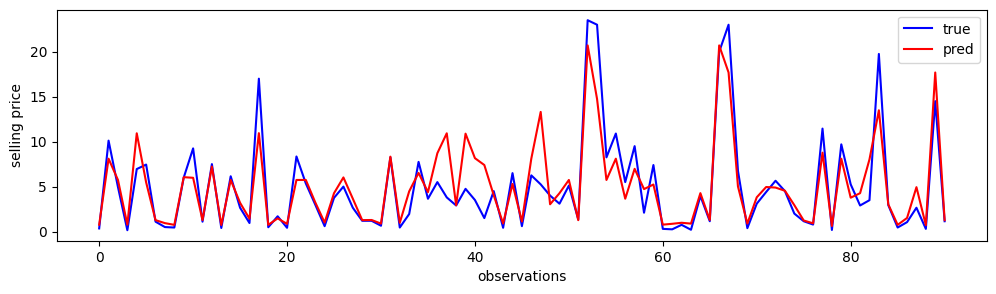

In [102]:
plt.figure(figsize=(12, 3))
plt.plot(y_val.values, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')

plt.xlabel("observations")
plt.ylabel("selling price")

plt.legend(loc='best')

plt.show()

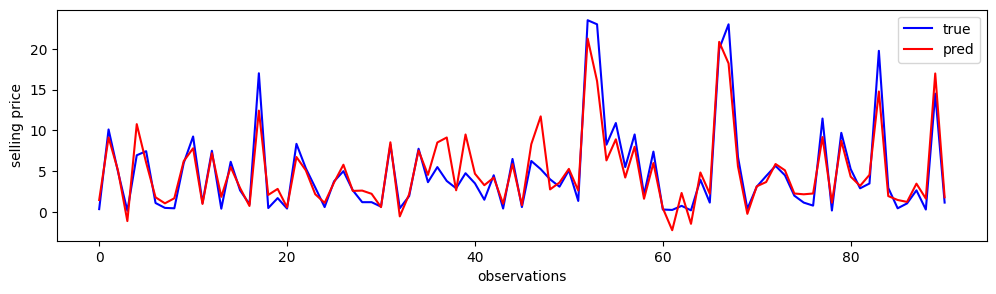

In [114]:
plt.figure(figsize=(12, 3))
plt.plot(y_val.values, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')

plt.xlabel("observations")
plt.ylabel("selling price")

plt.legend(loc='best')

plt.show()

In [103]:
show_reg_metrics(y_pred, y_val)

MSE:   6.1227132475159145
RMSE:  2.474411697255716
R2:    0.7849733048557006
MAE:   1.5608103345265185
MedAE: 0.6282081510128599


In [112]:
regressionModel = LinearRegression()
regressionModel.fit(X_train_v2, y_train)
y_pred = regressionModel.predict(X_val_v2)
print(pd.Series(regressionModel.coef_, index=regressionModel.feature_names_in_).sort_values(ascending=False))
print()
show_reg_metrics(y_pred, y_val)

Present_Price             0.570775
Transmission_Automatic    0.226174
Kms_Driven_log           -0.004400
Years_ago                -0.408448
Owner                    -0.765261
dtype: float64

MSE:   3.649086837320498
RMSE:  1.910258316909129
R2:    0.8718458547373689
MAE:   1.3059816557035588
MedAE: 0.9769253753333533


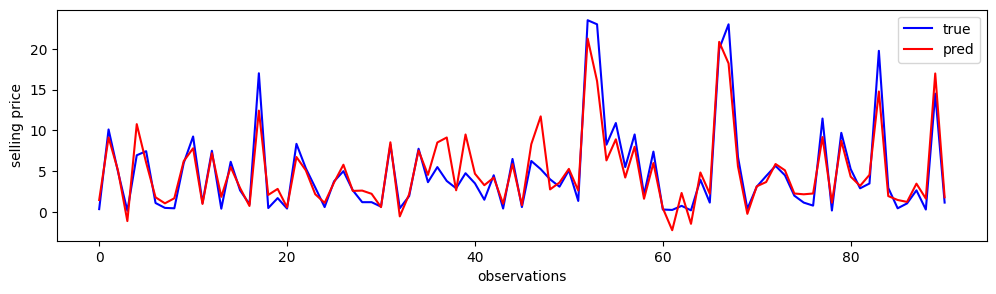

In [113]:
plt.figure(figsize=(12, 3))
plt.plot(y_val.values, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')

plt.xlabel("observations")
plt.ylabel("selling price")

plt.legend(loc='best')

plt.show()

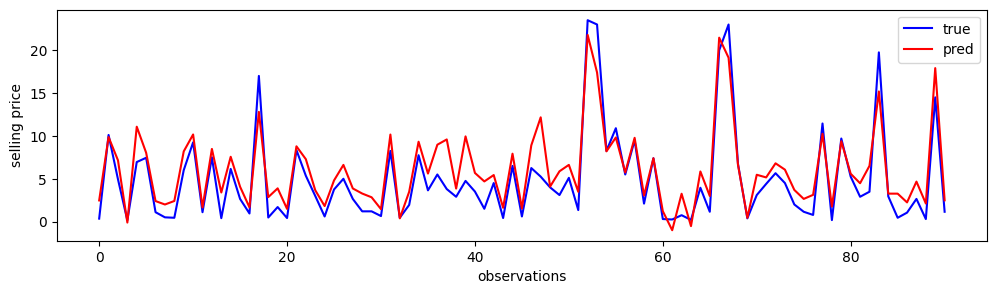

In [116]:
plt.figure(figsize=(12, 3))
plt.plot(y_val.values, 'b-', label='true')
plt.plot(y_pred, 'r-', label='pred')

plt.xlabel("observations")
plt.ylabel("selling price")

plt.legend(loc='best')

plt.show()

In [115]:
regressionModel = LinearRegression()
regressionModel.fit(X_train_v3, y_train)
y_pred = regressionModel.predict(X_val_v3)
print(pd.Series(regressionModel.coef_, index=regressionModel.feature_names_in_).sort_values(ascending=False))
print()
show_reg_metrics(y_pred, y_val)

Present_Price             0.503320
Transmission             -0.080912
Transmission_Automatic   -0.080912
Kms_Driven_log           -0.208191
Years_ago                -0.349119
Fuel_Type_Petrol         -0.383578
Fuel_Type_Diesel         -0.383578
Fuel_Type                -0.383578
Seller_Type_Individual   -0.418718
Seller_Type              -0.418718
Owner                    -0.595807
dtype: float64

MSE:   4.786794759365866
RMSE:  2.187874484371959
R2:    0.8318901088732036
MAE:   1.734028532770718
MedAE: 1.5009272069945792


Using all the features allowed us to improve the result (this is not always the case)

### **3.2 Ridge Regression (L2) & In-built cross validation**

[Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge)

In our case, the model does quite well without regularization. However, it's worth a try.

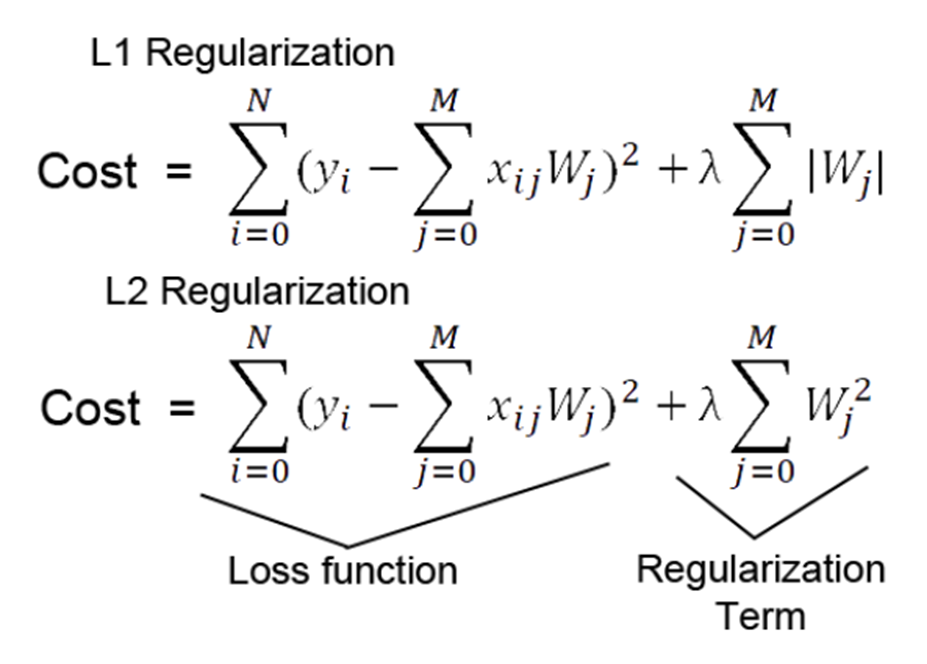

At the same time, we can learn to select a regularization parameter using cross-validation.

![](https://dataaspirant.com/wp-content/uploads/2020/12/10-K-Fold-Cross-Validation.png)

In addition to the usual Ridge regression, sklearn has a Ridge regression with built-in cross-validation.  
It uses **Leave-one-out cross-validation** by default.  


![](https://i.ytimg.com/vi/CnOe5BmrsgE/maxresdefault.jpg)

In [117]:
ridge_model = Ridge(alpha=2)

If we set parameter *cv* as a number *n*, the dataset is split into *n* parts. *n-1* parts are used for training, and the remaining part is used for validation (estimation). The process is repeated until all the parts have been used as test parts. Then the scoring value is averaged over n vals.

In [126]:
ridge_model = RidgeCV(alphas=np.array(range(1, 100, 1))/10, # the regularization parameters to choose from
                                  cv=5, # cross validation parameter
                                 scoring='neg_mean_squared_error')

# neg_mean_squared_error is a MSE with a minus
# why minus?
# the issue of sklearn conventions:
# All scorer objects follow the convention that higher return values are better than lower return values
# This only applies to scorers (in the case of loss functions, the opposite is true)

In [129]:
%%time

ridge_model.fit(X_train_v3, y_train) # our alphas

CPU times: user 1.94 s, sys: 80.2 ms, total: 2.02 s
Wall time: 2.22 s


RidgeCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
        cv=5, scoring='neg_mean_squared_error')

If the alpha extreme value is selected, it makes sense to change the range and restart the selection process.

In [130]:
ridge_model.alpha_ # the chosen alpha parameter

9.8

In [131]:
ridge_model.best_score_ # the score of neg MSE

-2.2809869311283935

In [125]:
y_pred = ridge_model.predict(X_val_v3)
print(pd.Series(ridge_model.coef_, index=ridge_model.feature_names_in_).sort_values(ascending=False))
print()
show_reg_metrics(y_pred, y_val)

Present_Price             0.505038
Transmission_Automatic   -0.071525
Transmission             -0.071525
Kms_Driven_log           -0.199869
Years_ago                -0.351945
Fuel_Type                -0.375304
Fuel_Type_Petrol         -0.375304
Fuel_Type_Diesel         -0.375304
Seller_Type_Individual   -0.405517
Seller_Type              -0.405517
Owner                    -0.485892
dtype: float64

MSE:   4.712801183111787
RMSE:  2.1708987040190952
R2:    0.8344887270871593
MAE:   1.7112350727933523
MedAE: 1.473916015402601


In [132]:
y_pred = ridge_model.predict(X_val_v3)
print(pd.Series(ridge_model.coef_, index=ridge_model.feature_names_in_).sort_values(ascending=False))
print()
show_reg_metrics(y_pred, y_val)

Present_Price             0.510686
Transmission             -0.045641
Transmission_Automatic   -0.045641
Kms_Driven_log           -0.172028
Owner                    -0.287011
Fuel_Type_Diesel         -0.345869
Fuel_Type_Petrol         -0.345869
Fuel_Type                -0.345869
Years_ago                -0.359545
Seller_Type              -0.359835
Seller_Type_Individual   -0.359835
dtype: float64

MSE:   4.498240787059067
RMSE:  2.120905652559554
R2:    0.8420239832729339
MAE:   1.6422854653714494
MedAE: 1.3890829751164055


### **3.3 Lasso Regression (L1) & In-built cross validation**

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)

In [133]:
lasso_model = LassoCV(alphas=np.array(range(1, 50, 1))/10,
                                  cv=5)
# classical MSE as scoring

In [134]:
%%time

lasso_model.fit(X_train_v3, y_train) # our alphas

CPU times: user 42.8 ms, sys: 8.64 ms, total: 51.5 ms
Wall time: 67.8 ms


LassoCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
        cv=5)

In [135]:
print(lasso_model.alpha_)
print(lasso_model.mse_path_[1:5]) # MSE for each fold and alpha

0.1
[[5.8022567  6.46274858 1.7322689  4.42906198 4.4276387 ]
 [5.75993301 6.43354248 1.72103228 4.41669082 4.38470844]
 [5.71827672 6.40505693 1.71001311 4.40481604 4.34256021]
 [5.67728784 6.37729193 1.6992114  4.39343764 4.301194  ]]


In [136]:
lasso_model.mse_path_.shape

(49, 5)

In [137]:
y_pred = lasso_model.predict(X_val_v3)
print(pd.Series(lasso_model.coef_, index=lasso_model.feature_names_in_).sort_values(ascending=False))
print()
show_reg_metrics(y_pred, y_val)

Present_Price             5.440409e-01
Transmission              0.000000e+00
Owner                    -0.000000e+00
Kms_Driven_log           -0.000000e+00
Seller_Type_Individual   -0.000000e+00
Transmission_Automatic    0.000000e+00
Fuel_Type_Diesel         -2.896234e-16
Fuel_Type_Petrol         -4.783052e-02
Seller_Type              -1.403922e-01
Years_ago                -3.986253e-01
Fuel_Type                -4.124895e-01
dtype: float64

MSE:   3.717655591156141
RMSE:  1.9281222967322744
R2:    0.8694377536339204
MAE:   1.3784905366335225
MedAE: 0.9459685447112562


Obviously, lasso regression is not needed for our data (the minimum parameter is selected).

See also [Elastic net regularization](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)

### **3.4 Polynomial regression**

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)

In some cases, when the dependency between X and y is non-linear, indroducing polinomial features can lead to better results.

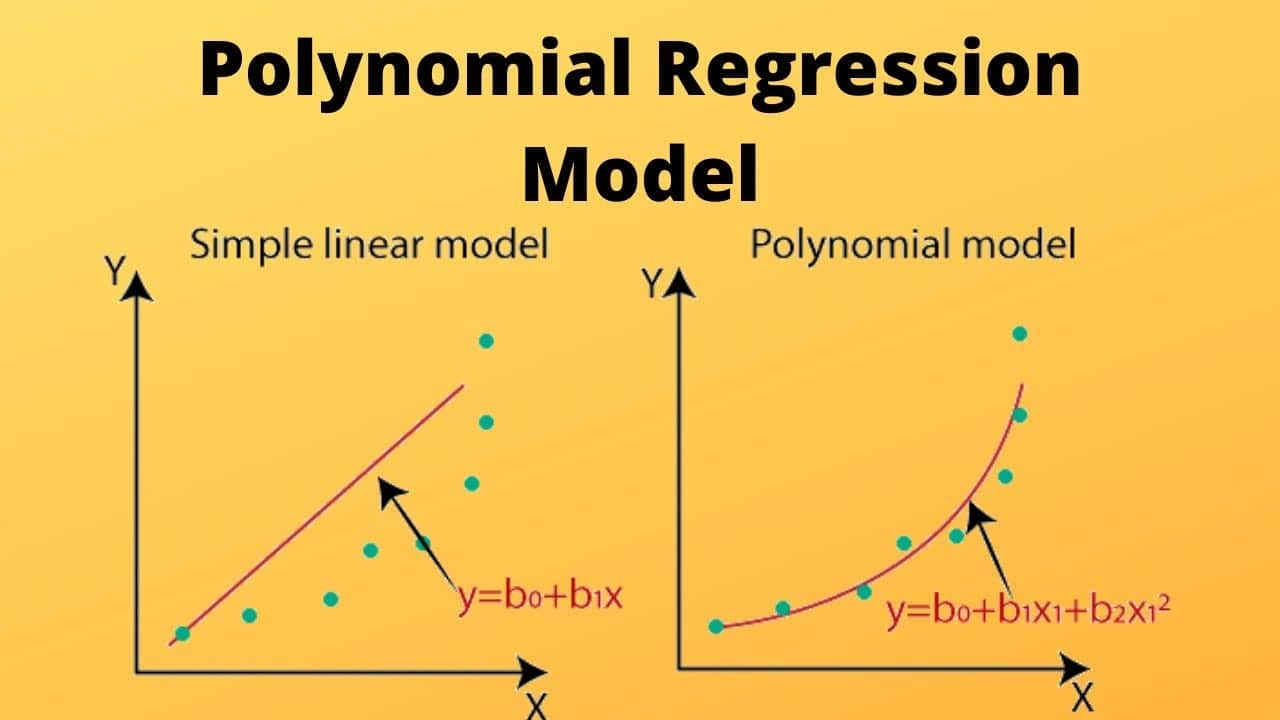

**Be careful with the choice of degree**: the higher the degree, the more the model adjusts to the data (the error drops during training, and jumps into the sky during validation = high bias and low variance)

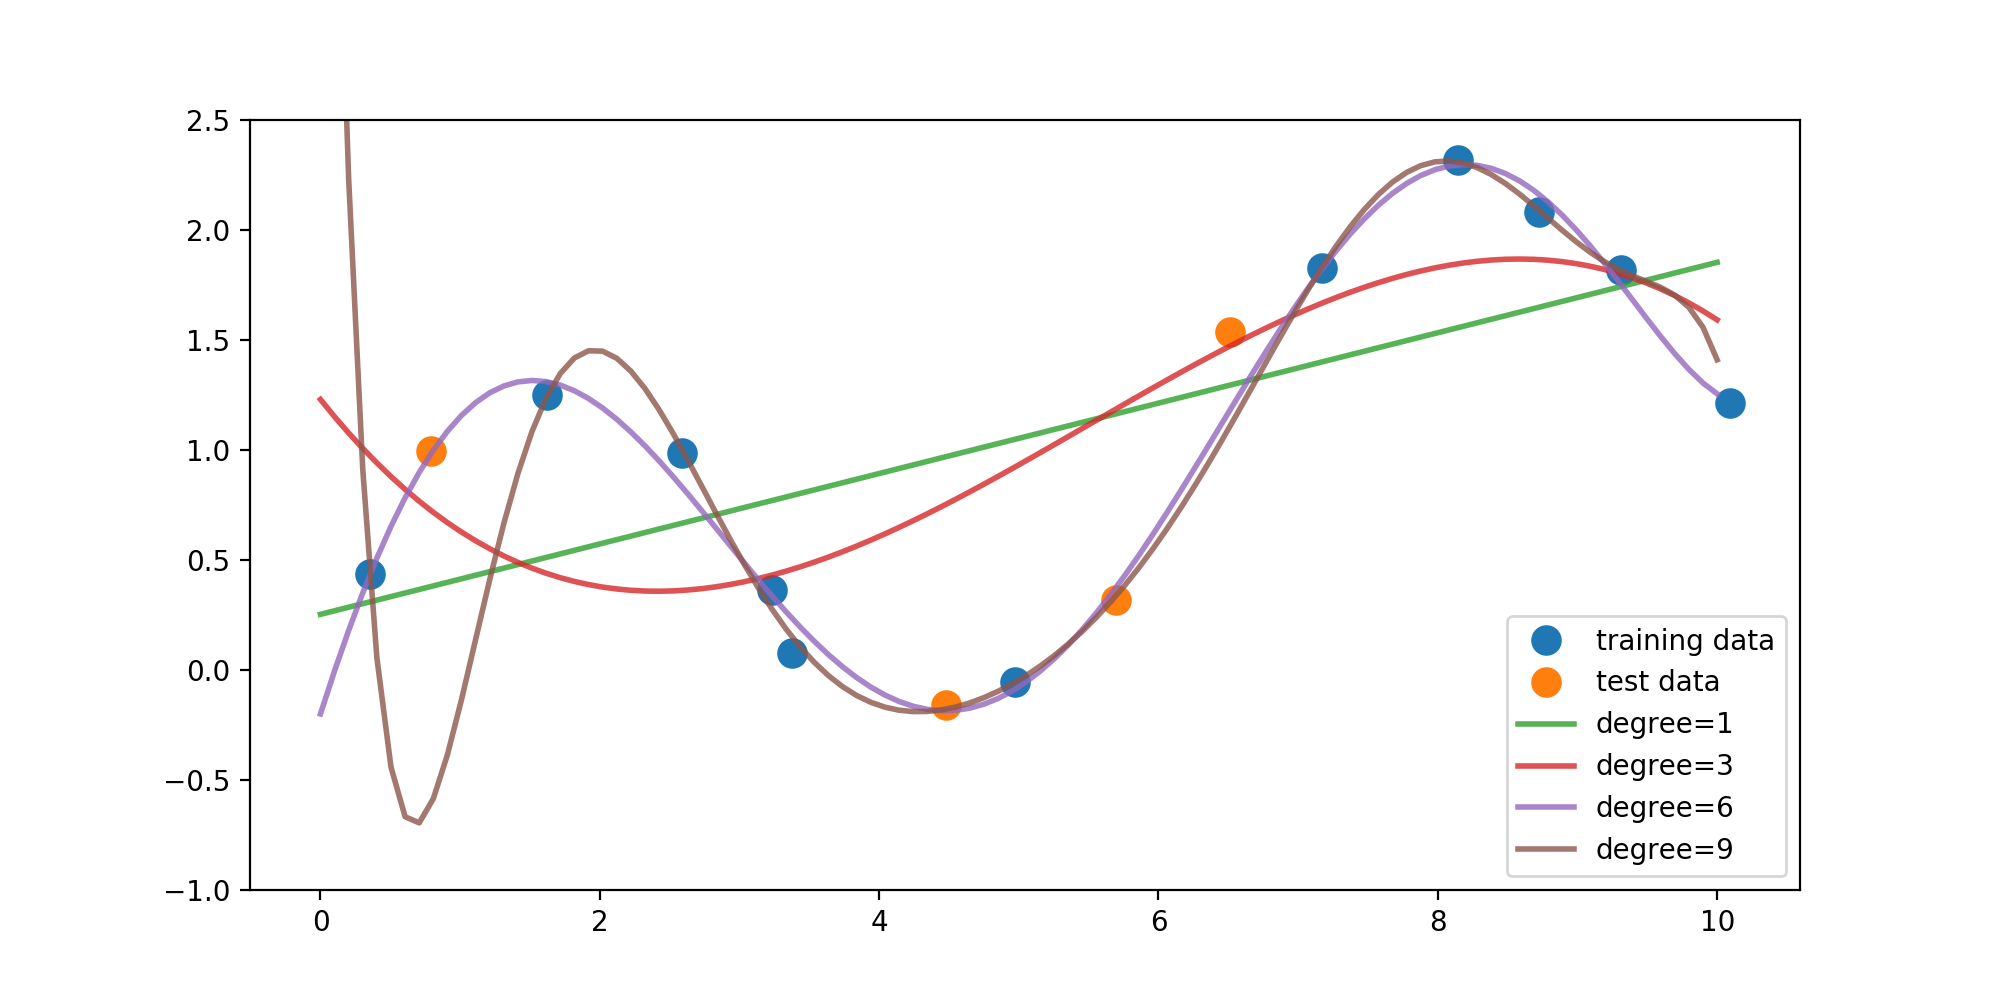

**PolynomialFeatures** is a transformer object that generates a new feature matrix consisting of all polynomial combinations of the features with degree less than or equal to the specified degree.  
For example, if an input sample is two dimensional and of the form [a, b], the degree-2 polynomial features are [1, a, b, a^2, ab, b^2].

Parameters:  
- degree - the maximum degree of polinomial  
- include_bias - adds a column with the zero degree of polinomial (= the column of ones)  
- interaction_only - polinomials like a^2, a^3, b^2 etc. are excluded.

In [138]:
from sklearn.preprocessing import PolynomialFeatures

In [139]:
poly = PolynomialFeatures(degree=2, include_bias=False)

Let's transform only one feature:

In [140]:
poly_features = poly.fit_transform(X_train_v3[['Present_Price']])

In [142]:
poly_features

array([[5.800000e-01, 3.364000e-01],
       [1.861000e+01, 3.463321e+02],
       [1.079000e+01, 1.164241e+02],
       [3.600000e+00, 1.296000e+01],
       [1.100000e+01, 1.210000e+02],
       [1.374000e+01, 1.887876e+02],
       [5.700000e+00, 3.249000e+01],
       [2.280000e+00, 5.198400e+00],
       [1.079000e+01, 1.164241e+02],
       [1.750000e+00, 3.062500e+00],
       [7.500000e+00, 5.625000e+01],
       [1.000000e+01, 1.000000e+02],
       [2.045000e+01, 4.182025e+02],
       [4.600000e+00, 2.116000e+01],
       [2.091000e+01, 4.372281e+02],
       [4.890000e+00, 2.391210e+01],
       [1.050000e+00, 1.102500e+00],
       [9.900000e-01, 9.801000e-01],
       [7.700000e+00, 5.929000e+01],
       [8.400000e-01, 7.056000e-01],
       [5.090000e+00, 2.590810e+01],
       [4.700000e-01, 2.209000e-01],
       [2.539000e+01, 6.446521e+02],
       [4.430000e+00, 1.962490e+01],
       [9.400000e-01, 8.836000e-01],
       [1.360000e+01, 1.849600e+02],
       [8.400000e-01, 7.056000e-01],
 

In [141]:
polin_price = pd.DataFrame(poly_features, index=X_train_v3.index, columns=['P', 'P2'])
polin_price

,P,P2
185,0.58,0.3364
72,18.61,346.3321
15,10.79,116.4241
10,3.60,12.9600
298,11.00,121.0000
...,...,...
188,0.57,0.3249
71,12.48,155.7504
106,3.45,11.9025
270,10.00,100.0000


Now we get two of them:

In [ ]:
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(X_train_v3[['Present_Price', 'Years_ago']])

In [ ]:
pd.DataFrame(poly_features, index=X_train_v3.index,
             columns=['Present_Price', 'Years_ago',
                      'Present_Price^2', 'Present_Price*Years_ago',
                      'Years_ago^2'])

,Present_Price,Years_ago,Present_Price^2,Present_Price*Years_ago,Years_ago^2
185,0.58,10.0,0.3364,5.80,100.0
72,18.61,5.0,346.3321,93.05,25.0
15,10.79,2.0,116.4241,21.58,4.0
10,3.60,1.0,12.9600,3.60,1.0
298,11.00,9.0,121.0000,99.00,81.0
...,...,...,...,...,...
188,0.57,5.0,0.3249,2.85,25.0
71,12.48,7.0,155.7504,87.36,49.0
106,3.45,4.0,11.9025,13.80,16.0
270,10.00,7.0,100.0000,70.00,49.0


We can get rid of features interacting with each other using the *interaction_only* parameter

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

In [ ]:
poly_features = poly.fit_transform(X_train_v3[['Present_Price', 'Years_ago']])

In [ ]:
pd.DataFrame(poly_features, index=X_train_v3.index)

,0,1,2
185,0.58,10.0,5.80
72,18.61,5.0,93.05
15,10.79,2.0,21.58
10,3.60,1.0,3.60
298,11.00,9.0,99.00
...,...,...,...
188,0.57,5.0,2.85
71,12.48,7.0,87.36
106,3.45,4.0,13.80
270,10.00,7.0,70.00


Let's try the polynomials for the entire dataset

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

In [ ]:
poly_features = poly.fit_transform(X_train_v3)

In [ ]:
poly_features.shape

(205, 77)

Always use **REGULARIZATION** with the polynomial.

In [ ]:
ridge_model = RidgeCV(alphas=np.array(range(1, 100, 1))/10, # the regularization parameters to choose from
                                  cv=5, # cross validation parameter
                                 scoring='neg_mean_squared_error')

In [ ]:
%%time

ridge_model.fit(poly_features, y_train) # our alphas

CPU times: user 2.29 s, sys: 3.07 s, total: 5.36 s
Wall time: 4.61 s


RidgeCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
        cv=5, scoring='neg_mean_squared_error')

In [ ]:
print(ridge_model.alpha_)

3.5


In [ ]:
y_pred = ridge_model.predict(poly_features)
show_reg_metrics(y_pred, y_train)

MSE:   0.33271117972040476
RMSE:  0.5768112167082092
R2:    0.9784249856000049
MAE:   0.407500035475467
MedAE: 0.26891312609564144


Let's remember about the validation sample

In [ ]:
poly_val = poly.transform(X_val_v3) # add polynomials to the validation

We get an almost perfect model (in comparison with all the others)

In [ ]:
y_pred = ridge_model.predict(poly_val)
show_reg_metrics(y_pred, y_val)

MSE:   0.7488789486339507
RMSE:  0.8653779224327084
R2:    0.9736997375382184
MAE:   0.5679054073572686
MedAE: 0.30824352063607163


What if we had chosen a bigger degree value?

In [ ]:
poly7 = PolynomialFeatures(degree=7, interaction_only=True, include_bias=False)
poly_features7 = poly7.fit_transform(X_train_v3)

ridge_model = RidgeCV(alphas=np.array(range(1, 100, 1))/10, # the regularization parameters to choose from
                                  cv=5, # cross validation parameter
                                 scoring='neg_mean_squared_error')

ridge_model.fit(poly_features7, y_train)

RidgeCV(alphas=array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9]),
        cv=5, scoring='neg_mean_squared_error')

In [ ]:
print(ridge_model.alpha_)
y_pred = ridge_model.predict(poly_features7)
show_reg_metrics(y_pred, y_train)

0.4
MSE:   0.3132482593836519
RMSE:  0.5596858577663473
R2:    0.9796870796086411
MAE:   0.3599374496159659
MedAE: 0.1679528797276788


In [ ]:
poly_val7 = poly7.transform(X_val_v3)
y_pred = ridge_model.predict(poly_val7)
show_reg_metrics(y_pred, y_val)

MSE:   2.1401602433813416
RMSE:  1.462928652867713
R2:    0.9248386188263484
MAE:   0.7422333055839804
MedAE: 0.22355486828065474


Overfitting is clearly visible.

## **4. Non-parametric models: KNN**

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

**The intuition behind KNN**:  
1. The training sample is all the cars that we have and for which we know the selling price. During the training, the data is simply remembered (there is no training). Therefore, if there is a lot of data, then the algorithm becomes heavy. We have a small amount, which is ok.  
2. During the validation process, for each vector-object-car from the validation sample, the distance for each vector-object-car from the training sample is calculated.  
3. The k objects closest (by the distance metric) are selected. If the weights for the neighbors are uniform (similar), the target value is averaged and assigned to the object from validation.  
  
**The most important hyperparameters**: 1) distance metric; 2) number of neighbors k; 3) weights of neighbors. Chosen on the cross-validation.   
  
**Question**: what if k is equal to 1? What if k is equal to the sample size?

In [ ]:
from sklearn.metrics.pairwise import distance_metrics

In [ ]:
distance_metrics().keys()

dict_keys(['cityblock', 'cosine', 'euclidean', 'haversine', 'l2', 'l1', 'manhattan', 'precomputed', 'nan_euclidean'])

cityblock = manhattan = l1  
euclidean = l2

 You can easily google the formula for the distance you need!

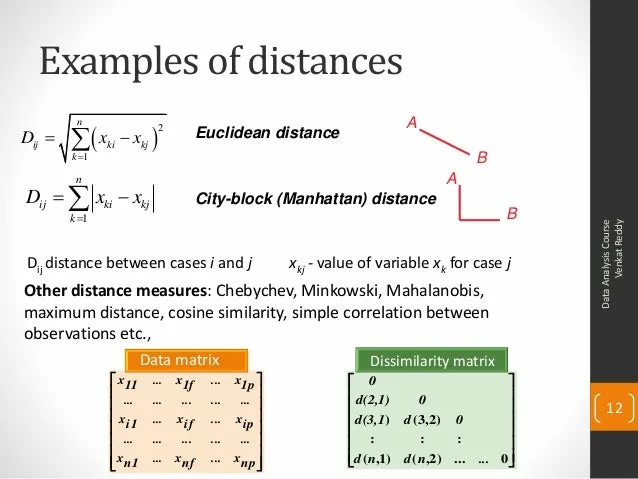

This example looks pretty nice (imagine that A and B are feature vectors in 2D space)

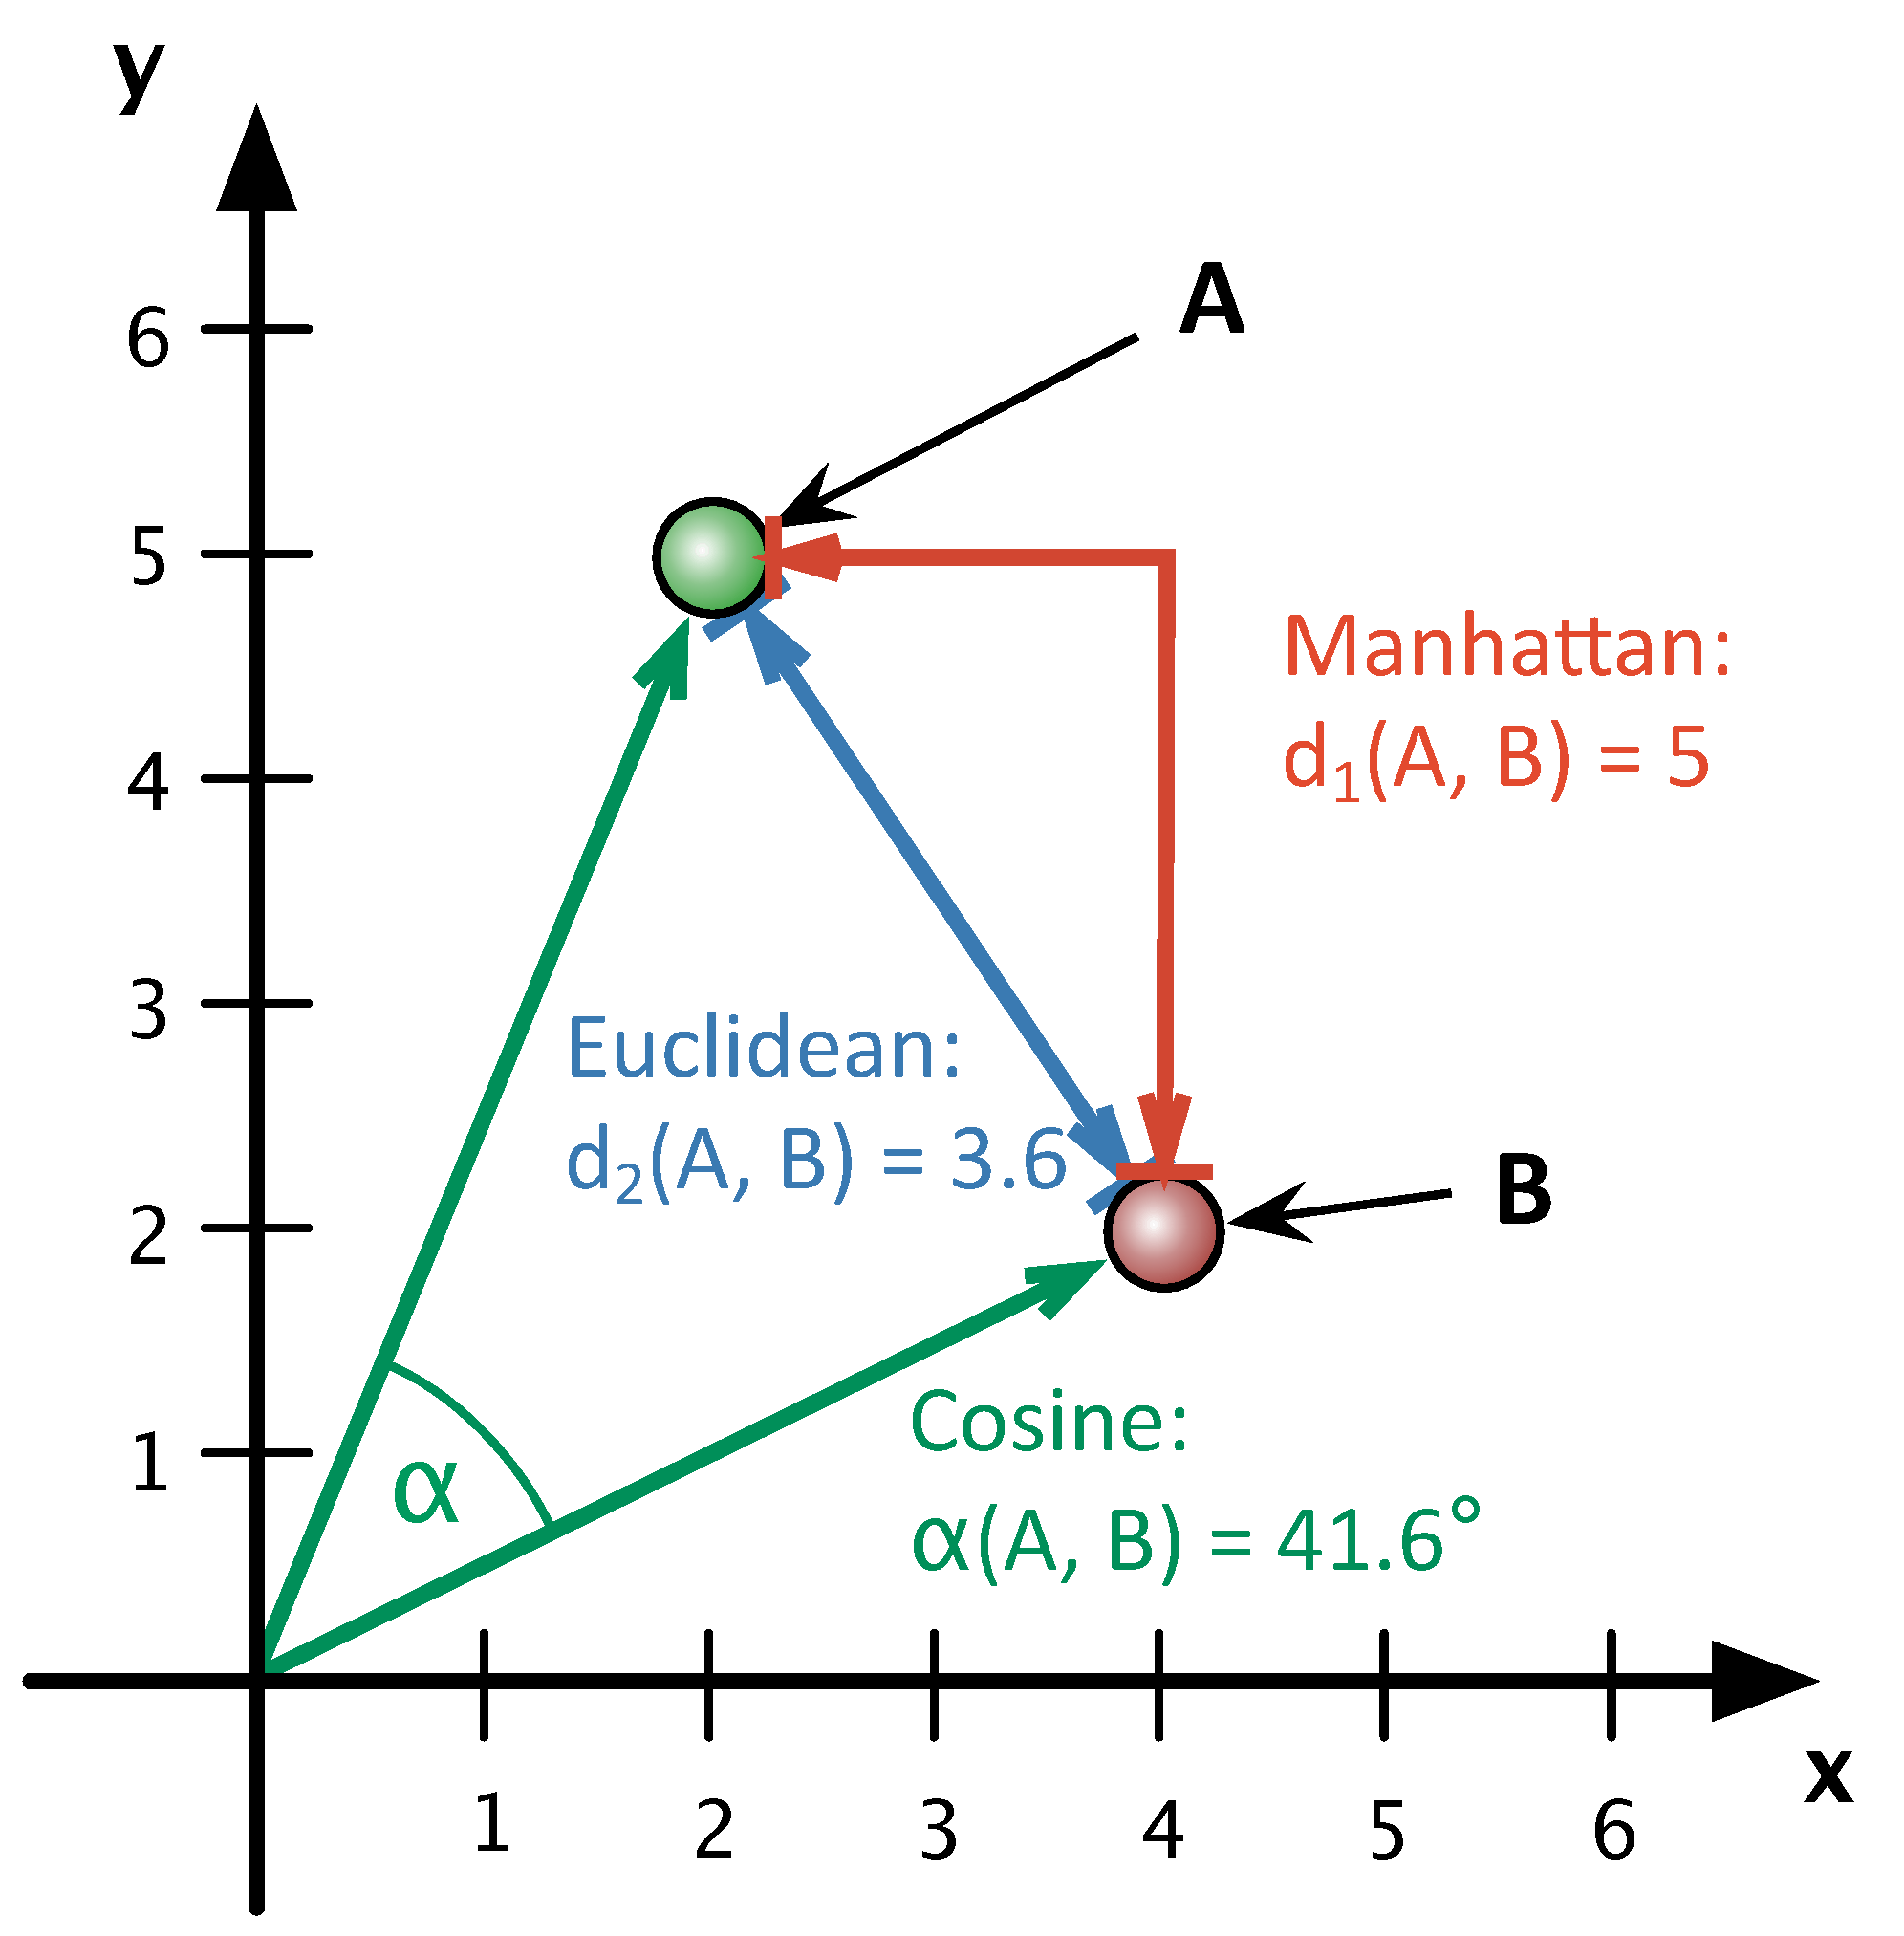

The formulas also can be found in the lecture slides. We'll talk about them in more detail when we get to clustering.

Example of euclidean and manhattan metrics computation:  
Train vector: [1, 2, 3]  
Val vector: [1, 10, 3]  
  
**l1** = sqrt((1 - 1)^2 + (2 - 10)^2 + (3 - 3)^2) = sqrt(0 + 64 + 0) = 8.  
**l2** = |1 - 1| + |2 - 10| + |3 - 3| = 8.

In [ ]:
from sklearn.metrics import DistanceMetric
dist_l2 = DistanceMetric.get_metric('euclidean')
dist_l1 = DistanceMetric.get_metric('manhattan')
X = [[1, 2, 3], [2, 3, 1]]
Y = [[1, 10, 3]]
print(dist_l2.pairwise(X,Y))
print(dist_l1.pairwise(X,Y))

[[8.        ]
 [7.34846923]]
[[ 8.]
 [10.]]


The Euclidean distance for the second pair of observations is smaller than Manhattan.

Have you forgotten that in the case of KNN, it is necessary to **standardize** the data?   
  
To simplify this process, we use a **pipeline**. A pipeline is an object that combines several transformers with an estimator (model) at the end. It allows us to avoid data leakage (that is, for example, during standardization, it calculates the average and deviation for training when we are fitting, and then applies it to validation when we are doing the prediction).

Create the pipeline object with transformers and estimator:

In [ ]:
pipe_knn = Pipeline(steps=[('scaler', StandardScaler()),
                       ('knn_reg', KNeighborsRegressor())])

In addition to Scalers, we can use all other types of transformers: Polynomials, Imputers, etc.

Label the hyperparameters as follows:

 [{objectname__hyperparameter: [list with hyperparameter values to validate], objectname__hyperparameter: [list with hyperparameter values to validate] ...}]

In [ ]:
tuned_parameters = [{'knn_reg__n_neighbors': np.arange(1, 30),
                     'knn_reg__metric': ['cityblock', 'cosine', 'euclidean'],
                     'knn_reg__weights': ['uniform', 'distance']
                     }
                    ]

Next, you need to select the **type of cross-validation**. Since we have a regression task, we will choose the usual KFold (as in the first picture in the 'Ridge' section).

In [ ]:
kf = KFold(n_splits=5, shuffle=True)

Further, depending on the number of parameter pairs and size of our training sample, we choose either a **greedy parameter search cross-validation** (**GridSearchCV**, long iterating through all pairs) or a **random parameter search cross-validation** (**RandomizedSearchCV**, some heuristics from sklearn, reduced accuracy, but increased speed).

In [ ]:
%%time

knn_regressor = GridSearchCV(
    pipe_knn,  # our pipeline
    tuned_parameters, # hyperparameters
    scoring='neg_mean_squared_error', # scoring func
    cv=kf,  # type of cross-validation
    verbose=1,
    n_jobs=-1)

knn_regressor.fit(X_train_v3, y_train)

Fitting 5 folds for each of 174 candidates, totalling 870 fits
CPU times: user 907 ms, sys: 95.4 ms, total: 1 s
Wall time: 15.3 s


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn_reg', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid=[{'knn_reg__metric': ['cityblock', 'cosine',
                                              'euclidean'],
                          'knn_reg__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                          'knn_reg__weights': ['uniform', 'distance']}],
             scoring='neg_mean_squared_error', verbose=1)

In [ ]:
knn_regressor.best_params_ # the chosen parameters

{'knn_reg__metric': 'cosine',
 'knn_reg__n_neighbors': 2,
 'knn_reg__weights': 'distance'}

In [ ]:
knn_regressor.best_score_ # MSE score

-1.0842072809404444

In [ ]:
my_knn_regressor = knn_regressor.best_estimator_ # save the best estimator

In [ ]:
y_preds = my_knn_regressor.predict(X_val_v3)

In [ ]:
show_reg_metrics(y_preds, y_val) # prediction on validation

MSE:   3.107355896944215
RMSE:  1.7627693828020201
R2:    0.8908711804479574
MAE:   0.8980154857883599
MedAE: 0.439856836049322


For our data, this algorithm works clearly worse than linear regression. At least, we have learned how to choose hyperparameters on cross-validation :)

**Task**:   
* Select the best number of neighbors and the distance metric (try other available metrics) for KNN Regressor with the fixed parameter **weights='distance'**.
* Use the **neg_median_absolute_error** as a scorer. When searching for hyperparameters, use a larger range of parameters and [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) instead of a greedy algorithm.

In [ ]:
# your code

# **Binary Classification Task**

## **1. Data Preparation**

We use [bank churn data](https://www.kaggle.com/datasets/rangalamahesh/bank-churn/data?select=train.csv)

In [ ]:
bank_data = pd.read_csv('/content/bank_train.csv')

Since there are a lot of objects, we use sampling.

In [ ]:
bank_data = bank_data.sample(frac=0.01, random_state=23)
bank_data.shape

(1650, 14)

In [ ]:
bank_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
22973,22973,15642636,Oluchi,550,Germany,Male,43.0,8,61318.14,1,1.0,1.0,184350.74,0
74837,74837,15634602,Brown,706,France,Male,37.0,9,0.00,1,1.0,0.0,149853.89,0
37799,37799,15702030,Findlay,584,Germany,Female,39.0,2,151963.26,2,1.0,0.0,158958.90,0
120710,120710,15718789,Lai,705,Spain,Female,41.0,8,123906.11,1,1.0,0.0,146033.08,0
93784,93784,15663888,Onwumelu,641,Germany,Female,35.0,3,131772.48,1,1.0,1.0,79919.13,0


In [ ]:
bank_data.isna().sum() # luckily data is without missing values

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
bank_data['Exited'].value_counts()

0    1308
1     342
Name: Exited, dtype: int64

Let's remove unnecessary (for our case) attributes

In [ ]:
bank_data.drop(['id', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [ ]:
X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(bank_data.drop('Exited', axis=1),
                                                  bank_data['Exited'],               # the target
                                                  test_size=0.3,                     # size of the test
                                                  random_state=42,                   # fixing the sample
                                                  stratify=bank_data['Exited'])      # DON'T FORGET

Looking at distributions of some variables

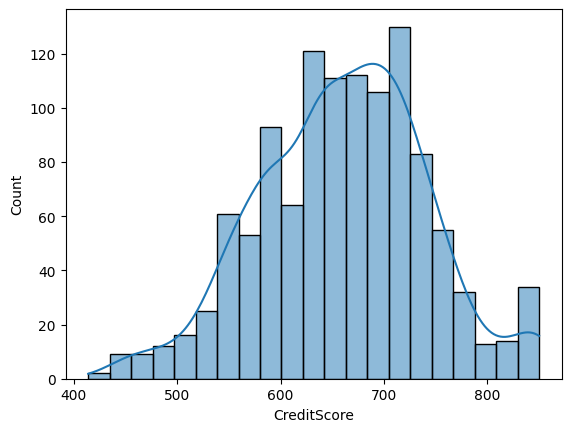

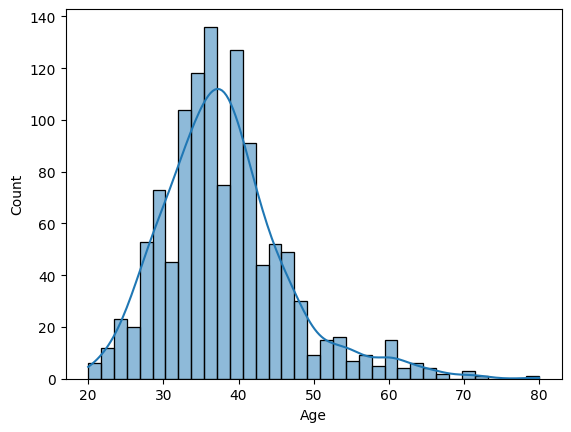

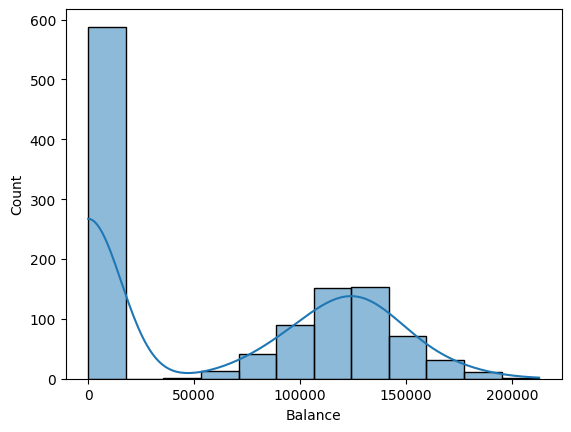

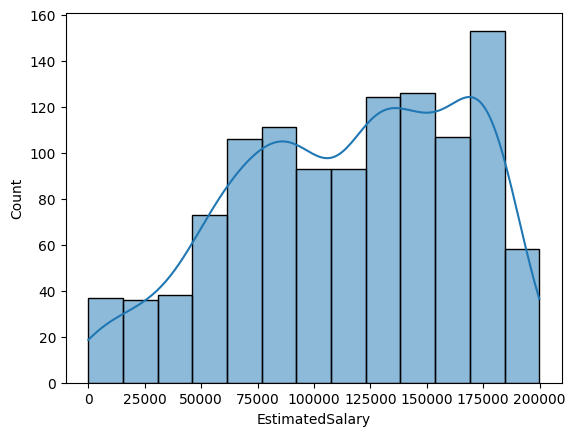

In [ ]:
for attr in X_train_b[['CreditScore', 'Age', 'Balance', 'EstimatedSalary']]:
  ax = sns.histplot(x=X_train_b[attr], kde=True)
  plt.show()

Let's look at the correlation

In [ ]:
X_train_b.join(y_train_b).corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.035686,-0.015274,0.018627,0.053271,0.000541,0.020966,0.005410,-0.061788
Age,-0.035686,1.000000,-0.008321,0.015818,-0.099108,-0.046172,-0.014859,0.037610,0.326222
Tenure,-0.015274,-0.008321,1.000000,0.074236,-0.021654,0.008280,-0.026584,0.000858,-0.017051
Balance,0.018627,0.015818,0.074236,1.000000,-0.344357,-0.044278,-0.036174,0.007720,0.155171
NumOfProducts,0.053271,-0.099108,-0.021654,-0.344357,1.000000,0.028442,0.059009,0.000449,-0.227485
HasCrCard,0.000541,-0.046172,0.008280,-0.044278,0.028442,1.000000,-0.028616,-0.034063,-0.023554
IsActiveMember,0.020966,-0.014859,-0.026584,-0.036174,0.059009,-0.028616,1.000000,0.015064,-0.208942
EstimatedSalary,0.005410,0.037610,0.000858,0.007720,0.000449,-0.034063,0.015064,1.000000,0.030761
Exited,-0.061788,0.326222,-0.017051,0.155171,-0.227485,-0.023554,-0.208942,0.030761,1.000000


It is very good that the attributes are completely uncorrelated with each other and some of them correlate with the target a little

Let's do a completely sloppy preprocessing.

Deleting the outliers using Z-score:

In [ ]:
z = stats.zscore(X_train_b.select_dtypes(include=[float, int]))

In [ ]:
z_mask = (np.abs(z) > 3).any(axis = 1)
X_train_b = X_train_b[~z_mask]
y_train_b = y_train_b[~z_mask]

In [ ]:
y_train_b.shape

(1136,)

In [ ]:
X_train_b.join(y_train_b).corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.048096,-0.015285,0.009756,0.052968,-0.001149,0.018243,0.001581,-0.058767
Age,-0.048096,1.000000,-0.008947,0.027324,-0.092750,-0.049973,-0.045248,0.048525,0.360316
Tenure,-0.015285,-0.008947,1.000000,0.075760,-0.017838,0.009143,-0.026231,0.001754,-0.014769
Balance,0.009756,0.027324,0.075760,1.000000,-0.362214,-0.045755,-0.031574,0.005716,0.152846
NumOfProducts,0.052968,-0.092750,-0.017838,-0.362214,1.000000,0.026318,0.071060,0.005389,-0.256515
HasCrCard,-0.001149,-0.049973,0.009143,-0.045755,0.026318,1.000000,-0.033676,-0.035436,-0.013038
IsActiveMember,0.018243,-0.045248,-0.026231,-0.031574,0.071060,-0.033676,1.000000,0.013438,-0.200624
EstimatedSalary,0.001581,0.048525,0.001754,0.005716,0.005389,-0.035436,0.013438,1.000000,0.032623
Exited,-0.058767,0.360316,-0.014769,0.152846,-0.256515,-0.013038,-0.200624,0.032623,1.000000


In [ ]:
np.log(X_train_b['NumOfProducts']).value_counts()

0.693147    591
0.000000    527
1.098612     18
Name: NumOfProducts, dtype: int64

After the outliers were removed, the correlation generally increased.

Let's look at the correlation with the log transformation of the numerical attributes:

In [ ]:
np.log(X_train_b.select_dtypes(include=[float, int]) + 0.001).join(y_train_b).corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.054448,-0.032733,-0.003405,0.055231,0.000955,0.020994,0.031417,-0.059847
Age,-0.054448,1.000000,-0.009571,0.030473,-0.090337,-0.049434,-0.053180,0.030452,0.337332
Tenure,-0.032733,-0.009571,1.000000,0.064264,0.002084,0.043327,0.023781,0.000227,-0.021945
Balance,-0.003405,0.030473,0.064264,1.000000,-0.402423,-0.042821,-0.030859,0.005317,0.149327
NumOfProducts,0.055231,-0.090337,0.002084,-0.402423,1.000000,0.027894,0.076953,-0.004684,-0.286164
HasCrCard,0.000955,-0.049434,0.043327,-0.042821,0.027894,1.000000,-0.033676,-0.061752,-0.013038
IsActiveMember,0.020994,-0.053180,0.023781,-0.030859,0.076953,-0.033676,1.000000,0.014172,-0.200624
EstimatedSalary,0.031417,0.030452,0.000227,0.005317,-0.004684,-0.061752,0.014172,1.000000,0.016076
Exited,-0.059847,0.337332,-0.021945,0.149327,-0.286164,-0.013038,-0.200624,0.016076,1.000000


Let's apply log transformation to the "number of products" variable:

In [ ]:
X_train_b['NumOfProducts_log'] = np.log(X_train_b['NumOfProducts'] + 0.001)
X_train_b.drop('NumOfProducts', axis=1, inplace=True)

X_val_b['NumOfProducts_log'] = np.log(X_val_b['NumOfProducts'] + 0.001)
X_val_b.drop('NumOfProducts', axis=1, inplace=True)

Categorical features encoding:

In [ ]:
ohe_encoder = ce.OneHotEncoder(cols = ['Geography', 'Gender'], use_cat_names=True)
# the columns that we want to encode are passed to the cols parameter

# the entire training dataframe is passed to the fit_transform method
X_train_b = ohe_encoder.fit_transform(X_train_b)

In [ ]:
X_val_b = ohe_encoder.transform(X_val_b) # transform validation

In [ ]:
X_train_b.head()

,CreditScore,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,NumOfProducts_log
114481,675,1,0,0,1,0,39.0,7,104541.53,1.0,1.0,73667.33,0.001000
153695,596,0,1,0,0,1,45.0,9,0.00,1.0,0.0,116951.10,0.001000
41318,556,1,0,0,0,1,35.0,1,0.00,1.0,0.0,180932.46,0.693647
57315,579,1,0,0,0,1,36.0,7,0.00,1.0,0.0,52861.89,0.693647
80480,627,1,0,0,1,0,31.0,3,0.00,1.0,0.0,144880.81,0.001000


Removing unnecessary attributes:

In [ ]:
X_train_b.drop(['Geography_Spain', 'Gender_Female'], axis=1, inplace=True)

In [ ]:
X_val_b.drop(['Geography_Spain', 'Gender_Female'], axis=1, inplace=True)

In [ ]:
X_train_b.join(y_train_b).corr()

,CreditScore,Geography_France,Geography_Germany,Gender_Male,Age,Tenure,Balance,HasCrCard,IsActiveMember,EstimatedSalary,NumOfProducts_log,Exited
CreditScore,1.000000,-0.040835,0.013615,-0.073418,-0.048096,-0.015285,0.009756,-0.001149,0.018243,0.001581,0.052822,-0.058767
Geography_France,-0.040835,1.000000,-0.610202,0.037294,-0.068772,-0.001423,-0.323522,0.045723,0.001242,-0.007652,0.094998,-0.146404
Geography_Germany,0.013615,-0.610202,1.000000,-0.004207,0.125595,0.008194,0.517957,-0.034798,-0.011065,0.017678,-0.165342,0.216087
Gender_Male,-0.073418,0.037294,-0.004207,1.000000,-0.009051,-0.002001,0.003835,0.040578,0.006508,-0.004858,0.010642,-0.127805
Age,-0.048096,-0.068772,0.125595,-0.009051,1.000000,-0.008947,0.027324,-0.049973,-0.045248,0.048525,-0.099570,0.360316
Tenure,-0.015285,-0.001423,0.008194,-0.002001,-0.008947,1.000000,0.075760,0.009143,-0.026231,0.001754,-0.015964,-0.014769
Balance,0.009756,-0.323522,0.517957,0.003835,0.027324,0.075760,1.000000,-0.045755,-0.031574,0.005716,-0.378795,0.152846
HasCrCard,-0.001149,0.045723,-0.034798,0.040578,-0.049973,0.009143,-0.045755,1.000000,-0.033676,-0.035436,0.027894,-0.013038
IsActiveMember,0.018243,0.001242,-0.011065,0.006508,-0.045248,-0.026231,-0.031574,-0.033676,1.000000,0.013438,0.076953,-0.200624
EstimatedSalary,0.001581,-0.007652,0.017678,-0.004858,0.048525,0.001754,0.005716,-0.035436,0.013438,1.000000,0.003557,0.032623


In [ ]:
X_train_b.shape

(1136, 11)

In [ ]:
X_val_b.shape

(495, 11)

## **2. Classification metrics**

In [ ]:
from plot_cm import plot_confusion_matrix

**Confusion matrix:**  [metrics.confusion_matrix](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

![](https://i.ytimg.com/vi/eQrkcFUWhJI/maxresdefault.jpg)

Positive class (1) = churn / sick / dead etc.  
Negative class (0) = non-churn / healthy / alive etc.  
**False positive** is a **type one error** (we find some phenomenon when it is actually absent)  
**False negative** is a **type two error** (we don't find a phenomenon which is present).

Note that the confusion matrix is often **inverted**. Pay attention to which axis contains the true values and which axis contains the predicted values.

**Accuracy:** [metrics.accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)  
$$Acc = \frac{TP + TN}{TP + FP + TN + FN}$$

How many objects we have detected correctly. All True values are divided by the total number of objects. It works well when the classes are balanced

**Precision:** [metrics.precision_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)  
$$Precision = \frac{TP}{TP + FP}$$

Of those who were predicted as churn, how many customers actually churn? 'the precision of guessing the class'.

Измеряем по отношению ко всем объектам, которые модель посчитала Positive

**Recall:** [metrics.recall_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)  
$$Recall = \frac{TP}{TP + FN}$$

How fully we detect the class?

Измеряем по отношению ко всем объектам класса positive

**F-score:** [metrics.f1_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score), [metrics.fbeta_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score)  
$$F = (1 + \beta^{2}) \cdot \frac{Precision \cdot Recall}{\beta^2 \cdot Precision + Recall}$$

$$F = \frac{TP}{TP + 0.5 \cdot (FP + FN)}$$

It takes into account each of the metrics. Beta is a weight of metrics importance. 1 - the same weight. The smaller the Beta, the more we value precision.

F1 score, precision and recall are metrics which are calculated per class, which means that if you want to calculate **the overall score** for a dataset with more than one class you will need to aggregate in some way. **Micro and macro averaging** are two ways of doing this aggregation.

**Macro averaging** = sum(scores) / number of classes  

**Micro averaging** - TPs, FPs and FNs are calculated for all classes; their averages go into the formula.

**Roc-Auc:** [metrics.roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve)  
$$FPR = \frac{FP}{FP + TN}, \text{ }  TPR (Sensitivity) = \frac{TP}{TP + FN}, \text{ } Specificity = 1 - FPR$$

**FPR** - доля неправильно предсказанных объектов класса Negative (хотим, чтобы была низкой)  
**TPR** - доля правильно предсказанных объектов класса Positive (хотим, чтобы была высокой)

The roc-curve takes into account both metrics (sensitivity and false positive rate). A graph is plotted for each threshold value (a probability threshold for assignment to the positive class). The area under the rock curve turns out to be large in the case when **FPR is small** and **TPR is large** for a larger number of points.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/1/13/Roc_curve.svg/1200px-Roc_curve.svg.png)

In [ ]:
def show_cls_metrics(y_trues, y_preds):
  print(classification_report(y_trues, y_preds))

  b_acc = balanced_accuracy_score(y_trues, y_preds)

  print("Balanced Accuracy: {0}".format(round(b_acc, 2)))

  plot_confusion_matrix(cm=metrics.confusion_matrix(y_trues, y_preds),
                      target_names=['0', '1'],
                      normalize=True) # normalize by rows

              precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6

Balanced Accuracy: 0.67


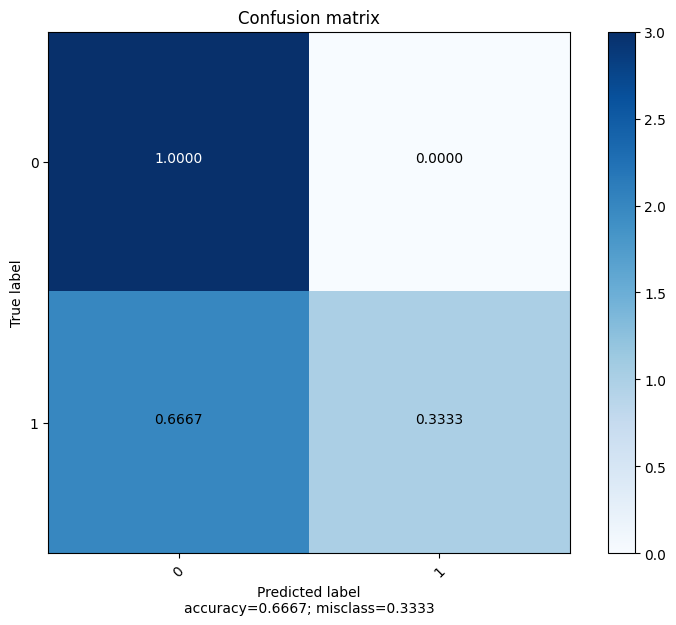

In [ ]:
show_cls_metrics([1, 1, 1, 0, 0, 0], [1, 0, 0, 0, 0, 0])

When **macro avg**, each class has weight of *1 / number of classes*  
When **weighted avg**, each class has weight that corresponds to its share in the sample.

## **3. Logistic Regression**

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Returning the probability estimate of belonging to the positive class.  

The model tries to train in such a way that predicting probabilities, they are closer to 1 for each class.

**The most important parameters**:  
1. **Penalty (regularization)** - l1, l2 or elastic net (i.e. both);
2. **C** - the inverse strength of regularization (the smaller, the stronger the regularization);  
3. **class_weight** - "attention" to classes, the higher the probability we give to a class, the more the model is penalized for incorrect predictions of this particular class. By default, the weights correspond to 1 for each class. But we can make it equal to the class shares in the training sample (class_weight='balanced').

### **3.1 Logistic regression from the box**

In [ ]:
lr = LogisticRegression()

In [ ]:
lr.fit(X_train_b, y_train_b)

LogisticRegression()

In [ ]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       392
           1       0.51      0.18      0.27       103

    accuracy                           0.79       495
   macro avg       0.67      0.57      0.58       495
weighted avg       0.75      0.79      0.75       495

Balanced Accuracy: 0.57


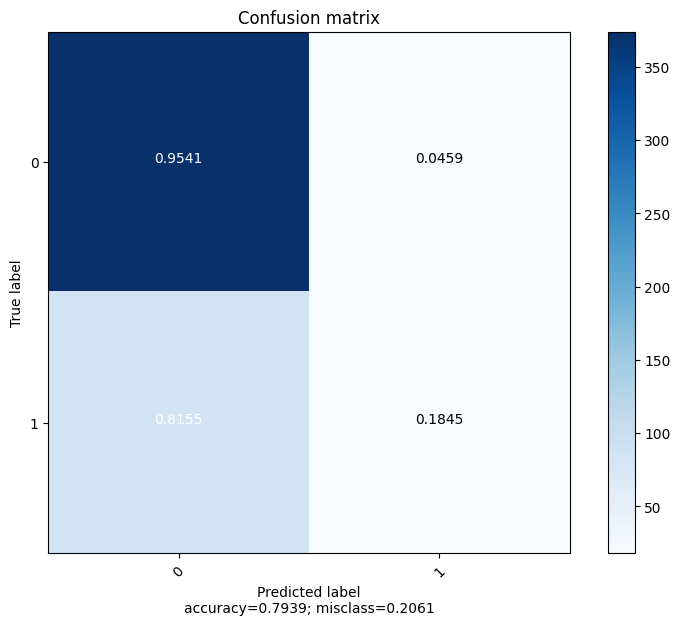

In [ ]:
y_preds = lr.predict(X_val_b)

show_cls_metrics(y_val_b, y_preds)

Regression 'from the box' has predicted the Positive class very poorly.

In [ ]:
y_train_b.value_counts()

0    904
1    232
Name: Exited, dtype: int64

              precision    recall  f1-score   support

           0       0.88      0.68      0.77       392
           1       0.35      0.66      0.46       103

    accuracy                           0.68       495
   macro avg       0.62      0.67      0.61       495
weighted avg       0.77      0.68      0.70       495

Balanced Accuracy: 0.67


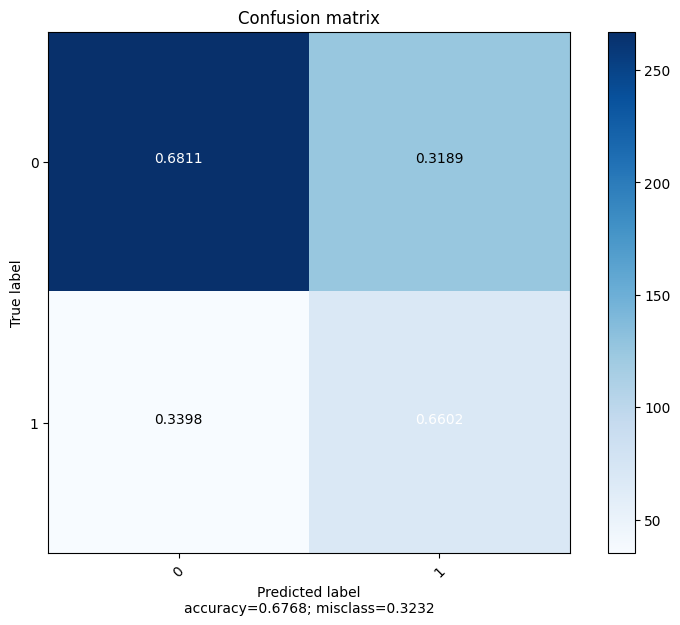

In [ ]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train_b, y_train_b)
y_preds = lr.predict(X_val_b)

show_cls_metrics(y_val_b, y_preds)

In [ ]:
print(pd.Series(lr.coef_.flatten(), index=lr.feature_names_in_).sort_values(ascending=False))
print()

Age                  9.298776e-02
Geography_Germany    1.717052e-03
Balance              6.009812e-06
EstimatedSalary     -8.492819e-07
HasCrCard           -4.451885e-05
Geography_France    -1.371518e-03
Gender_Male         -2.092801e-03
Tenure              -2.270329e-03
NumOfProducts_log   -2.834215e-03
IsActiveMember      -2.998815e-03
CreditScore         -5.989987e-03
dtype: float64



It looks better, but it's still not good enough.

### **3.2 Undestanding ROC-curve and AUC-ROC**

We use the built-in datasets from sklearn in order to understand the essence of the metric.

In [ ]:
from sklearn.datasets import load_breast_cancer
cancer_data = load_breast_cancer()

In [ ]:
np.random.seed(5)
features = cancer_data.data[:, :2] # use only 2 features
y = cancer_data.target # get the target (y_true)

In [ ]:
tr, val, y_tr, y_v = train_test_split(features, y, test_size=9, random_state=4)

In [ ]:
print(tr.shape)
print(val.shape) # we get only 9 objects for validation

(560, 2)
(9, 2)


Let's train the simplest logistic regression model.

In [ ]:
lr1 = LogisticRegression(random_state=3)
lr1.fit(tr, y_tr)

LogisticRegression(random_state=3)

Using the predict method, the model immediately returns predictions.

In [ ]:
lr1.predict(val)

array([1, 1, 0, 0, 0, 0, 1, 1, 1])

In [ ]:
y_v

array([1, 1, 0, 0, 1, 1, 1, 1, 0])

However, many classification algorithms in sklearn are also able to return the confidence (probability) of being a particular class.  
The left column shows the probability of being 0  
The right column shows the probability of being 1   

In [ ]:
y_probs = lr1.predict_proba(val)
y_probs

array([[0.27875649, 0.72124351],
       [0.10135027, 0.89864973],
       [0.99400373, 0.00599627],
       [0.96705983, 0.03294017],
       [0.84395505, 0.15604495],
       [0.90979974, 0.09020026],
       [0.00423093, 0.99576907],
       [0.00640508, 0.99359492],
       [0.4379921 , 0.5620079 ]])

We can define the **threshold** ourselves, after which we will consider the object belong to the target (Positive) class. By default, it is equal to 0.5.

In [ ]:
predicted = np.where(y_probs[:, 1] >= 0.5, 1, 0)
predicted

array([1, 1, 0, 0, 0, 0, 1, 1, 1])

We can play with the threshold and look at how the value of metrics changes:

In [ ]:
predicted = np.where(y_probs[:, 1] >= 0.9, 1, 0) # the bigger the thresh the more we are sure that the object is of the target class
predicted

array([0, 0, 0, 0, 0, 0, 1, 1, 0])

By **increasing** the threshold, we achieve **high precision** in predicting the **positive** (target) class, but **reduce its recall**.

When you set the threshold higher, you make the model "more conservative." It assigns the True label when it is "more confident." But as a consequence, you typically lower recall: you detect fewer examples of the target class overall.

When you set the threshold lower, you make the model "less strict." It assigns the True label more often, even when "less confident." Consequently, you increase recall: you will detect more examples of the target class. However, this may also lead to lower precision, as the model may make more False Positive predictions.

Choosing a threshold is a **trade-off between precision and recall**.

              precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       1.00      0.33      0.50         6

    accuracy                           0.56         9
   macro avg       0.71      0.67      0.55         9
weighted avg       0.81      0.56      0.53         9

Balanced Accuracy: 0.67


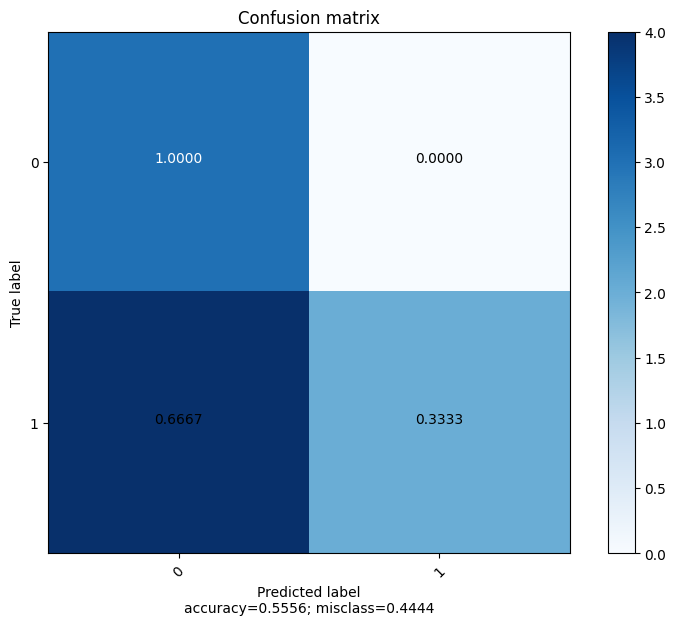

In [ ]:
show_cls_metrics(y_v, predicted)

Let's order our objects by the probabilities ascending:

In [ ]:
prob_data = pd.DataFrame({'Prob of being 1': y_probs[:, 1], 'y_true': y_v}).sort_values(by='Prob of being 1')
prob_data

,Prob of being 1,y_true
2,0.005996,0
3,0.032940,0
5,0.090200,1
4,0.156045,1
8,0.562008,0
0,0.721244,1
1,0.898650,1
7,0.993595,1
6,0.995769,1


Now let's add decisions for all possible thresholds in our data:

In [ ]:
all_probs = [0,] + sorted(y_probs[:, 1]) + [1,]

for prob in all_probs:
  predicted = np.where(np.array(sorted(y_probs[:, 1])) >= prob, 1, 0)
  column_name = 'thresh =' + str(round(prob, 3))
  prob_data[column_name] = predicted

In [ ]:
prob_data

,Prob of being 1,y_true,thresh =0,thresh =0.006,thresh =0.033,thresh =0.09,thresh =0.156,thresh =0.562,thresh =0.721,thresh =0.899,thresh =0.994,thresh =0.996,thresh =1
2,0.005996,0,1,1,0,0,0,0,0,0,0,0,0
3,0.032940,0,1,1,1,0,0,0,0,0,0,0,0
5,0.090200,1,1,1,1,1,0,0,0,0,0,0,0
4,0.156045,1,1,1,1,1,1,0,0,0,0,0,0
8,0.562008,0,1,1,1,1,1,1,0,0,0,0,0
0,0.721244,1,1,1,1,1,1,1,1,0,0,0,0
1,0.898650,1,1,1,1,1,1,1,1,1,0,0,0
7,0.993595,1,1,1,1,1,1,1,1,1,1,0,0
6,0.995769,1,1,1,1,1,1,1,1,1,1,1,0


Now let's remember about TPR and FPR:

$$FPR = \frac{FP}{FP + TN}, \text{ }  TPR (Sensitivity) = \frac{TP}{TP + FN}$$

**FPR** - доля неправильно предсказанных объектов класса Negative (хотим, чтобы была низкой)  
**TPR** - доля правильно предсказанных объектов класса Positive (хотим, чтобы была высокой)

Now let's start calculating the values of these metrics starting from the **highest threshold** (that is, moving from right to left on the table)

**thresh=1:**     TPR = 0, FPR = 0  
**thresh=0.996:** TPR = 1/6, FPR = 0  
...  
**thresh =0.562**  TPR = 4/6, FPR = 1/3  
...  
**thresh =0.09**  TPR = 1, FPR = 1/3  
...  
**thresh =0**  TPR = 1, FPR = 1  

**Conclusion: FOR AN IDEAL MODEL, TPR SHOULD REACH 1 BEFORE THE FPR BECOMES > 0.**

This is achieved when sorting data by probability ascending, **all objects of class 1 are perfectly separated from the objects of class 0**.   
In other words: it is possible to choose such a threshold, that no single mistake is made.

The worst case would be if objects of different classes met in turn (1, 0, 1, 0, 1...) after sorting.

This is what **ROC curve** actually shows:

In [ ]:
from sklearn.metrics import roc_curve
fprs, tprs, thr = roc_curve(y_v, y_probs[:, 1])

In [ ]:
print(fprs)
print(tprs)
print(thr)

[0.         0.         0.         0.33333333 0.33333333 1.        ]
[0.         0.16666667 0.66666667 0.66666667 1.         1.        ]
[1.99576907 0.99576907 0.72124351 0.5620079  0.09020026 0.00599627]


Text(0.5, 1.0, 'ROC_curve')

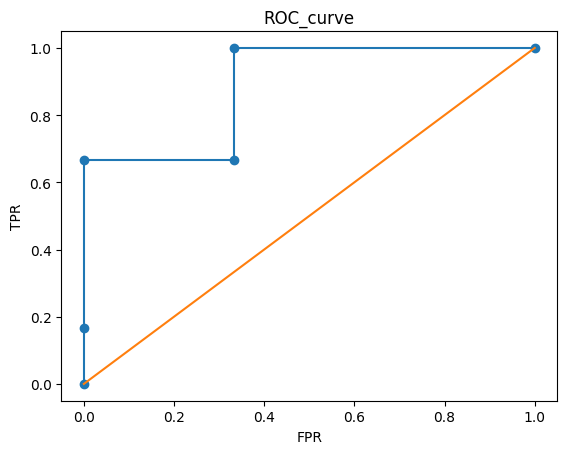

In [ ]:
fig, ax = plt.subplots()

ax.plot(fprs, tprs, marker='o')
ax.plot([0, 1], [0, 1], linestyle='-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_curve')

The diagonal line is the worst model. The blue line is our model.  
The curve of an ideal model goes through the point (1, 1)  
The curve of real-life models is usually located between the diagonal and the point (1, 1)  

Quantification of this metric is the area under the ROC curve, called **AUC-ROC** (1 - the best, 0.5 - the worst)

In [ ]:
roc_auc_score(y_v, y_probs[:, 1])

0.888888888888889

If you still have questions, read the [article](https://www.evidentlyai.com/classification-metrics/explain-roc-curve)

### **3.3 Improving logistic regression result + ROC-curve**

Let's use the pipeline, add standardization and polynomial features:

In [ ]:
pipe_logistic = Pipeline(steps=[('scaler', StandardScaler()),
                                ('p_nom', PolynomialFeatures(degree=3, include_bias=False)),
                       ('lr', LogisticRegression())])

In [ ]:
tuned_parameters = [{'lr__penalty': ['l1', 'l2'],
                     'lr__C': [1, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 25, 30, 45, 50, 100, 500],
                     'lr__class_weight': ['balanced', None]
                     }]

When we perform cross-validation during classification task, we need to use stratification, so that the class ratio is maintained within the folds.

In [ ]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
skf = StratifiedKFold(n_splits=5)

Next, you need to designate a **scoring function**

The list of metrics can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html)

In [ ]:
my_scorer = make_scorer(f1_score, average='macro') # like this
# or just pass the name to the scoring param

Let's start searching for **hyperparameters**:

In [ ]:
%%time

logistic = GridSearchCV(
    pipe_logistic,  # our pipeline
    tuned_parameters, # hyperparameters
    scoring='f1_macro', # scoring func
    cv=skf,  # type of cross-validation
    verbose=1,
    n_jobs=-1)

logistic.fit(X_train_b, y_train_b)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: user 832 ms, sys: 64.7 ms, total: 897 ms
Wall time: 13 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('p_nom',
                                        PolynomialFeatures(degree=3,
                                                           include_bias=False)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'lr__C': [1, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20,
                                    25, 30, 45, 50, 100, 500],
                          'lr__class_weight': ['balanced', None],
                          'lr__penalty': ['l1', 'l2']}],
             scoring='f1_macro', verbose=1)

In [ ]:
logistic.best_params_

{'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2'}

In [ ]:
logistic.best_score_

0.6948430230274034

In [ ]:
best_logistic = logistic.best_estimator_ # save the best estimator

In [ ]:
y_probs = best_logistic.predict_proba(X_val_b)[:, 1] # get the probabilities
y_preds = best_logistic.predict(X_val_b)  # get the predictions for the 0.5 threshold

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       392
           1       0.55      0.54      0.55       103

    accuracy                           0.81       495
   macro avg       0.72      0.71      0.72       495
weighted avg       0.81      0.81      0.81       495

Balanced Accuracy: 0.71


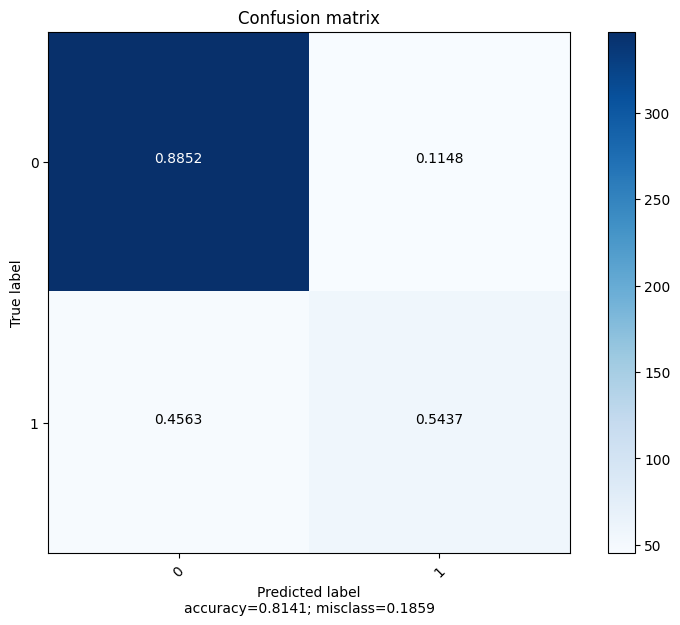

In [ ]:
show_cls_metrics(y_val_b, y_preds)

Text(0.5, 1.0, 'ROC_curve')

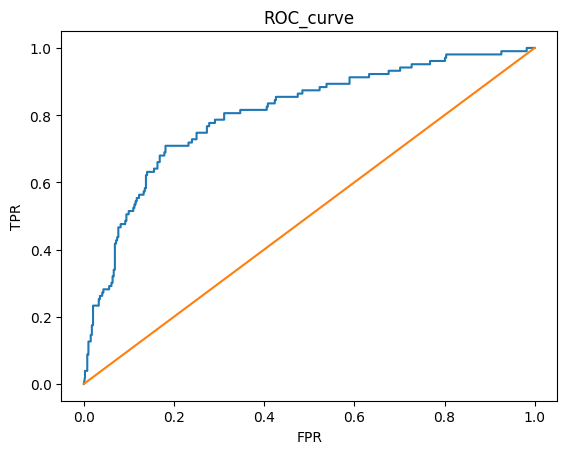

In [ ]:
fprs, tprs, thr = roc_curve(y_val_b, y_probs)

fig, ax = plt.subplots()

ax.plot(fprs, tprs)
ax.plot([0, 1], [0, 1], linestyle='-')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC_curve')

In [ ]:
roc_auc_score(y_val_b, y_probs)

0.8050822270655835

**Task**:

Select the logistic regression threshold at which the macro f-score metric will be the best.  
Tip: the code from this and the previous section may help you.

In [ ]:
# your code